In [1]:
"""
Over the air domain adaptation.

4 Modulations: bpsk, qpsk, 16qam and 16apsk.
Source SNR as 24, target from 10 to 22.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "16apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/ota_X.npy")
Y = np.load(file_path + "/ota_Y.npy")

sou_snr = 24
tar_snr = 10

t_base_acc = []
t_dann_acc = []
t_star_acc = []
t_mcd_acc = []
t_coral_acc = []
t_jan_acc = []

s_base_acc = []
s_dann_acc = []
s_star_acc = []
s_mcd_acc = []
s_coral_acc = []
s_jan_acc = []

n_runs = 3
lr = 0.002

for i in range(7):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    s_base, t_base = base.Base(model_cls=base.CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)
    
    s_dan, t_dan = dann.DAN(dann.DANN, FA=dann.CLDNN_FA, LP=dann.CLDNN_LP, DC=dann.CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=25, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dan)
    t_dann_acc.append(t_dan)
    
    s_star, t_star = star.Star(G=star.CLDNN_G, C=star.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)
    
    s_mcd, t_mcd = mcd.Mcd(G=mcd.CLDNN_G, C=mcd.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)
    
    s_coral, t_coral = coral.Coral(G=coral.CLDNN_G, C=coral.CLDNN_C, device=device, S_train_loader=S_train_loader,
                           S_val_loader=S_val_loader, T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                           class_subset=class_subset, n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs,
                           patience=5, lambda_coral=0.5).run()
    torch.cuda.empty_cache()
    s_coral_acc.append(s_coral)
    t_coral_acc.append(t_coral)

    s_jan, t_jan = jan.Jan(num_classes=len(class_subset), device=device, S_train_loader=S_train_loader,
                     T_train_loader=T_train_loader, S_val_loader=S_val_loader, T_val_loader=T_val_loader,
                     n_epochs=50, lr=lr, lambda_jmmd=0.1, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_jan_acc.append(s_jan)
    t_jan_acc.append(t_jan)
    
    tar_snr += 2


Run 1/3
Epoch 1/50, Train Loss: 1.4094, Train Acc: 0.2581, Val Loss: 1.3724, Val Acc: 0.2444
Epoch 2/50, Train Loss: 1.2701, Train Acc: 0.4829, Val Loss: 0.6804, Val Acc: 0.5505
Epoch 3/50, Train Loss: 0.4888, Train Acc: 0.7663, Val Loss: 0.3377, Val Acc: 0.7995
Epoch 4/50, Train Loss: 0.6359, Train Acc: 0.7558, Val Loss: 0.1987, Val Acc: 0.9158
Epoch 5/50, Train Loss: 0.6384, Train Acc: 0.7538, Val Loss: 0.1086, Val Acc: 0.9603
Epoch 6/50, Train Loss: 1.3338, Train Acc: 0.7611, Val Loss: 0.5670, Val Acc: 0.8065
Epoch 7/50, Train Loss: 0.8344, Train Acc: 0.8112, Val Loss: 0.6922, Val Acc: 0.7247
Epoch 8/50, Train Loss: 0.6175, Train Acc: 0.8108, Val Loss: 0.0357, Val Acc: 0.9921
Epoch 9/50, Train Loss: 0.3800, Train Acc: 0.8767, Val Loss: 0.3005, Val Acc: 0.8962
Epoch 10/50, Train Loss: 0.3051, Train Acc: 0.8937, Val Loss: 0.0243, Val Acc: 0.9899
Epoch 11/50, Train Loss: 0.0216, Train Acc: 0.9940, Val Loss: 0.0099, Val Acc: 0.9963
Epoch 12/50, Train Loss: 0.0162, Train Acc: 0.9953, Va

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1604, Domain Loss: 1.6724, Class Loss: 1.4880
Epoch 2/25, Loss: 2.7876, Domain Loss: 1.3880, Class Loss: 1.3996
Epoch 3/25, Loss: 2.7795, Domain Loss: 1.3864, Class Loss: 1.3931
Epoch 4/25, Loss: 2.7826, Domain Loss: 1.3862, Class Loss: 1.3964
Epoch 5/25, Loss: 2.7760, Domain Loss: 1.3859, Class Loss: 1.3902
Epoch 6/25, Loss: 2.7643, Domain Loss: 1.3867, Class Loss: 1.3776
Epoch 7/25, Loss: 2.8930, Domain Loss: 1.4819, Class Loss: 1.4111
Epoch 8/25, Loss: 2.8975, Domain Loss: 1.4985, Class Loss: 1.3990
Epoch 9/25, Loss: 2.7856, Domain Loss: 1.3926, Class Loss: 1.3930
Epoch 10/25, Loss: 2.7765, Domain Loss: 1.3861, Class Loss: 1.3905
Epoch 11/25, Loss: 2.7737, Domain Loss: 1.3854, Class Loss: 1.3883
Epoch 12/25, Loss: 2.7772, Domain Loss: 1.3856, Class Loss: 1.3916
Epoch 13/25, Loss: 2.7752, Domain Loss: 1.3856, Class Loss: 1.3895
Epoch 14/25, Loss: 2.7765, Domain Loss: 1.3858, Class Loss: 1.3906
Epoch 15/25, Loss: 2.7729, Domain Loss: 1.3859, Class Loss: 1.3870
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1241, Domain Loss: 1.6123, Class Loss: 1.5119
Epoch 2/25, Loss: 2.7883, Domain Loss: 1.3879, Class Loss: 1.4004
Epoch 3/25, Loss: 2.7829, Domain Loss: 1.3878, Class Loss: 1.3951
Epoch 4/25, Loss: 2.7716, Domain Loss: 1.3866, Class Loss: 1.3850
Epoch 5/25, Loss: 2.7798, Domain Loss: 1.3863, Class Loss: 1.3935
Epoch 6/25, Loss: 2.8287, Domain Loss: 1.3923, Class Loss: 1.4364
Epoch 7/25, Loss: 2.6945, Domain Loss: 1.3896, Class Loss: 1.3049
Epoch 8/25, Loss: 2.3581, Domain Loss: 1.3887, Class Loss: 0.9694
Epoch 9/25, Loss: 2.5734, Domain Loss: 1.3708, Class Loss: 1.2026
Epoch 10/25, Loss: 14.5694, Domain Loss: 12.8372, Class Loss: 1.7323
Epoch 11/25, Loss: 24.5247, Domain Loss: 23.1149, Class Loss: 1.4099
Epoch 12/25, Loss: 4.5005, Domain Loss: 3.1044, Class Loss: 1.3962
Epoch 13/25, Loss: 2.8706, Domain Loss: 1.4816, Class Loss: 1.3889
Epoch 14/25, Loss: 2.7834, Domain Loss: 1.3921, Class Loss: 1.3913
Epoch 15/25, Loss: 2.7753, Domain Loss: 1.3862, Class Loss: 1.3891


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 9.8921, Discrepancy Loss: 0.1052
Epoch [2/50], Class Loss: 0.5649, Discrepancy Loss: 0.1272
Epoch [3/50], Class Loss: 0.2455, Discrepancy Loss: 0.1266
Epoch [4/50], Class Loss: 0.1566, Discrepancy Loss: 0.1076
Epoch [5/50], Class Loss: 0.1123, Discrepancy Loss: 0.1002
Epoch [6/50], Class Loss: 0.1310, Discrepancy Loss: 0.1041
Epoch [7/50], Class Loss: 0.0813, Discrepancy Loss: 0.1003
Epoch [8/50], Class Loss: 0.0982, Discrepancy Loss: 0.1088
Epoch [9/50], Class Loss: 0.0671, Discrepancy Loss: 0.0964
Epoch [10/50], Class Loss: 0.0935, Discrepancy Loss: 0.0984
Epoch [11/50], Class Loss: 0.0452, Discrepancy Loss: 0.1005
Epoch [12/50], Class Loss: 0.0415, Discrepancy Loss: 0.0976
Epoch [13/50], Class Loss: 0.0464, Discrepancy Loss: 0.1049
Epoch [14/50], Class Loss: 0.0439, Discrepancy Loss: 0.0980
Epoch [15/50], Class Loss: 0.0403, Discrepancy Loss: 0.0896
Epoch [16/50], Class Loss: 0.0498, Discrepancy Loss: 0.1003
Epoch [17/50], Class Loss: 0.0447, Discrepancy Lo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4152, Train Acc: 0.2655, Val Loss: 1.2514, Val Acc: 0.2508
Epoch 2/50, Train Loss: 0.9370, Train Acc: 0.4950, Val Loss: 1.1811, Val Acc: 0.2466
Epoch 3/50, Train Loss: 0.6209, Train Acc: 0.6944, Val Loss: 0.5745, Val Acc: 0.7180
Epoch 4/50, Train Loss: 1.1821, Train Acc: 0.5539, Val Loss: 1.4068, Val Acc: 0.2466
Epoch 5/50, Train Loss: 0.6875, Train Acc: 0.6593, Val Loss: 1.1695, Val Acc: 0.6109
Epoch 6/50, Train Loss: 0.5465, Train Acc: 0.7648, Val Loss: 0.2943, Val Acc: 0.8508
Epoch 7/50, Train Loss: 0.8890, Train Acc: 0.6279, Val Loss: 0.7315, Val Acc: 0.5633
Epoch 8/50, Train Loss: 0.5448, Train Acc: 0.7866, Val Loss: 0.6869, Val Acc: 0.7257
Epoch 9/50, Train Loss: 0.3778, Train Acc: 0.8450, Val Loss: 0.8381, Val Acc: 0.6591
Epoch 10/50, Train Loss: 0.5900, Train Acc: 0.8051, Val Loss: 0.0656, Val Acc: 0.9838
Epoch 11/50, Train Loss: 0.0645, Train Acc: 0.9785, Val Loss: 0.0462, Val Acc: 0.9847
Epoch 12/50, Train Loss: 0.0548, Train Acc: 0.9796, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4166, Train Acc: 0.2569, Val Loss: 1.3591, Val Acc: 0.2399
Epoch 2/50, Train Loss: 1.1216, Train Acc: 0.5039, Val Loss: 0.3683, Val Acc: 0.7769
Epoch 3/50, Train Loss: 1.1261, Train Acc: 0.6139, Val Loss: 0.9410, Val Acc: 0.5087
Epoch 4/50, Train Loss: 0.9617, Train Acc: 0.6045, Val Loss: 0.2570, Val Acc: 0.9149
Epoch 5/50, Train Loss: 0.7134, Train Acc: 0.7608, Val Loss: 0.1783, Val Acc: 0.9234
Epoch 6/50, Train Loss: 0.7398, Train Acc: 0.7485, Val Loss: 0.1397, Val Acc: 0.9402
Epoch 7/50, Train Loss: 0.6700, Train Acc: 0.8035, Val Loss: 0.1317, Val Acc: 0.9451
Epoch 8/50, Train Loss: 0.7273, Train Acc: 0.8139, Val Loss: 0.0819, Val Acc: 0.9716
Epoch 9/50, Train Loss: 0.2298, Train Acc: 0.9207, Val Loss: 0.3372, Val Acc: 0.8572
Epoch 10/50, Train Loss: 0.6849, Train Acc: 0.7810, Val Loss: 0.9998, Val Acc: 0.5191
Epoch 11/50, Train Loss: 0.1035, Train Acc: 0.9632, Val Loss: 0.0342, Val Acc: 0.9933
Epoch 12/50, Train Loss: 0.0425, Train Acc: 0.9869, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0187, Domain Loss: 1.4857, Class Loss: 1.5330
Epoch 2/25, Loss: 2.7987, Domain Loss: 1.3860, Class Loss: 1.4127
Epoch 3/25, Loss: 2.7757, Domain Loss: 1.3833, Class Loss: 1.3924
Epoch 4/25, Loss: 2.9442, Domain Loss: 1.5453, Class Loss: 1.3990
Epoch 5/25, Loss: 16.3437, Domain Loss: 14.8529, Class Loss: 1.4908
Epoch 6/25, Loss: 6.0741, Domain Loss: 4.6732, Class Loss: 1.4009
Epoch 7/25, Loss: 2.9827, Domain Loss: 1.5882, Class Loss: 1.3945
Epoch 8/25, Loss: 2.7910, Domain Loss: 1.3992, Class Loss: 1.3918
Epoch 9/25, Loss: 2.7788, Domain Loss: 1.3889, Class Loss: 1.3899
Epoch 10/25, Loss: 2.7781, Domain Loss: 1.3884, Class Loss: 1.3897
Epoch 11/25, Loss: 2.7760, Domain Loss: 1.3886, Class Loss: 1.3874
Epoch 12/25, Loss: 2.7776, Domain Loss: 1.3890, Class Loss: 1.3886
Epoch 13/25, Loss: 2.7790, Domain Loss: 1.3895, Class Loss: 1.3895
Epoch 14/25, Loss: 2.7801, Domain Loss: 1.3901, Class Loss: 1.3901
Epoch 15/25, Loss: 2.7788, Domain Loss: 1.3908, Class Loss: 1.3880
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.2234, Domain Loss: 1.6363, Class Loss: 1.5871
Epoch 2/25, Loss: 2.7841, Domain Loss: 1.3848, Class Loss: 1.3993
Epoch 3/25, Loss: 2.7759, Domain Loss: 1.3837, Class Loss: 1.3922
Epoch 4/25, Loss: 2.7866, Domain Loss: 1.3894, Class Loss: 1.3972
Epoch 5/25, Loss: 2.7959, Domain Loss: 1.4031, Class Loss: 1.3928
Epoch 6/25, Loss: 2.7841, Domain Loss: 1.3984, Class Loss: 1.3858
Epoch 7/25, Loss: 2.7666, Domain Loss: 1.3826, Class Loss: 1.3839
Epoch 8/25, Loss: 2.9756, Domain Loss: 1.4359, Class Loss: 1.5397
Epoch 9/25, Loss: 2.7888, Domain Loss: 1.3882, Class Loss: 1.4005
Epoch 10/25, Loss: 2.7368, Domain Loss: 1.3713, Class Loss: 1.3655
Epoch 11/25, Loss: 2.9714, Domain Loss: 1.5034, Class Loss: 1.4680
Epoch 12/25, Loss: 2.8284, Domain Loss: 1.4090, Class Loss: 1.4193
Epoch 13/25, Loss: 2.7935, Domain Loss: 1.3997, Class Loss: 1.3938
Epoch 14/25, Loss: 2.8119, Domain Loss: 1.4191, Class Loss: 1.3927
Epoch 15/25, Loss: 2.8323, Domain Loss: 1.4448, Class Loss: 1.3874
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.2441, Domain Loss: 1.6795, Class Loss: 1.5646
Epoch 2/25, Loss: 2.7814, Domain Loss: 1.3855, Class Loss: 1.3960
Epoch 3/25, Loss: 2.7748, Domain Loss: 1.3843, Class Loss: 1.3905
Epoch 4/25, Loss: 2.7777, Domain Loss: 1.3875, Class Loss: 1.3902
Epoch 5/25, Loss: 2.9043, Domain Loss: 1.5125, Class Loss: 1.3919
Epoch 6/25, Loss: 3.6423, Domain Loss: 2.0827, Class Loss: 1.5596
Epoch 7/25, Loss: 2.8688, Domain Loss: 1.4636, Class Loss: 1.4052
Epoch 8/25, Loss: 2.8556, Domain Loss: 1.4628, Class Loss: 1.3928
Epoch 9/25, Loss: 2.9527, Domain Loss: 1.5611, Class Loss: 1.3916
Epoch 10/25, Loss: 3.3377, Domain Loss: 1.9515, Class Loss: 1.3861
Epoch 11/25, Loss: 5.1824, Domain Loss: 3.7885, Class Loss: 1.3939
Epoch 12/25, Loss: 4.4934, Domain Loss: 3.1019, Class Loss: 1.3915
Epoch 13/25, Loss: 3.6516, Domain Loss: 2.2621, Class Loss: 1.3895
Epoch 14/25, Loss: 3.9650, Domain Loss: 2.5781, Class Loss: 1.3868
Epoch 15/25, Loss: 5.7067, Domain Loss: 4.3195, Class Loss: 1.3872
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 12.5196, Discrepancy Loss: 0.0921
Epoch [2/50], Class Loss: 1.0658, Discrepancy Loss: 0.1124
Epoch [3/50], Class Loss: 0.2429, Discrepancy Loss: 0.1037
Epoch [4/50], Class Loss: 0.1539, Discrepancy Loss: 0.1080
Epoch [5/50], Class Loss: 0.1275, Discrepancy Loss: 0.1013
Epoch [6/50], Class Loss: 0.1042, Discrepancy Loss: 0.1149
Epoch [7/50], Class Loss: 0.1580, Discrepancy Loss: 0.1130
Epoch [8/50], Class Loss: 0.0796, Discrepancy Loss: 0.1232
Epoch [9/50], Class Loss: 0.0529, Discrepancy Loss: 0.1183
Epoch [10/50], Class Loss: 0.0659, Discrepancy Loss: 0.1228
Epoch [11/50], Class Loss: 0.0536, Discrepancy Loss: 0.1336
Epoch [12/50], Class Loss: 0.0434, Discrepancy Loss: 0.1354
Epoch [13/50], Class Loss: 0.0381, Discrepancy Loss: 0.1285
Epoch [14/50], Class Loss: 0.0385, Discrepancy Loss: 0.1248
Epoch [15/50], Class Loss: 0.0343, Discrepancy Loss: 0.1216
Epoch [16/50], Class Loss: 0.0275, Discrepancy Loss: 0.1198
Epoch [17/50], Class Loss: 0.0294, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4195, Train Acc: 0.2529, Val Loss: 1.3855, Val Acc: 0.2475
Epoch 2/50, Train Loss: 1.4485, Train Acc: 0.4516, Val Loss: 0.2445, Val Acc: 0.9185
Epoch 3/50, Train Loss: 0.8973, Train Acc: 0.6455, Val Loss: 0.6427, Val Acc: 0.6222
Epoch 4/50, Train Loss: 0.5708, Train Acc: 0.7353, Val Loss: 0.2275, Val Acc: 0.8920
Epoch 5/50, Train Loss: 0.6483, Train Acc: 0.8112, Val Loss: 0.3007, Val Acc: 0.8676
Epoch 6/50, Train Loss: 0.4309, Train Acc: 0.8508, Val Loss: 0.1495, Val Acc: 0.9353
Epoch 7/50, Train Loss: 0.2900, Train Acc: 0.9079, Val Loss: 1.0312, Val Acc: 0.7635
Epoch 8/50, Train Loss: 0.2618, Train Acc: 0.9062, Val Loss: 0.0487, Val Acc: 0.9854
Epoch 9/50, Train Loss: 0.5649, Train Acc: 0.8118, Val Loss: 0.0898, Val Acc: 0.9689
Epoch 10/50, Train Loss: 0.5291, Train Acc: 0.8562, Val Loss: 0.0833, Val Acc: 0.9704
Epoch 11/50, Train Loss: 0.0157, Train Acc: 0.9959, Val Loss: 0.0230, Val Acc: 0.9939
Epoch 12/50, Train Loss: 0.0107, Train Acc: 0.9979, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.3964, Train Acc: 0.2674, Val Loss: 0.8359, Val Acc: 0.5066
Epoch 2/50, Train Loss: 0.6617, Train Acc: 0.6762, Val Loss: 0.4248, Val Acc: 0.7647
Epoch 3/50, Train Loss: 0.8296, Train Acc: 0.7142, Val Loss: 0.5282, Val Acc: 0.7193
Epoch 4/50, Train Loss: 0.7230, Train Acc: 0.7568, Val Loss: 0.4393, Val Acc: 0.7730
Epoch 5/50, Train Loss: 0.7471, Train Acc: 0.6386, Val Loss: 0.9035, Val Acc: 0.5130
Epoch 6/50, Train Loss: 0.4825, Train Acc: 0.7546, Val Loss: 0.3466, Val Acc: 0.8364
Epoch 7/50, Train Loss: 0.2958, Train Acc: 0.8659, Val Loss: 3.9660, Val Acc: 0.2756
Epoch 8/50, Train Loss: 0.7475, Train Acc: 0.7778, Val Loss: 0.1401, Val Acc: 0.9429
Epoch 9/50, Train Loss: 0.1352, Train Acc: 0.9462, Val Loss: 0.1633, Val Acc: 0.9286
Epoch 10/50, Train Loss: 0.3761, Train Acc: 0.8676, Val Loss: 0.0927, Val Acc: 0.9747
Epoch 11/50, Train Loss: 0.0861, Train Acc: 0.9686, Val Loss: 0.0732, Val Acc: 0.9768
Epoch 12/50, Train Loss: 0.0676, Train Acc: 0.9771, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0991, Domain Loss: 1.5688, Class Loss: 1.5303
Epoch 2/25, Loss: 2.7806, Domain Loss: 1.3851, Class Loss: 1.3955
Epoch 3/25, Loss: 2.7741, Domain Loss: 1.3844, Class Loss: 1.3898
Epoch 4/25, Loss: 2.7758, Domain Loss: 1.3876, Class Loss: 1.3883
Epoch 5/25, Loss: 2.7899, Domain Loss: 1.3946, Class Loss: 1.3952
Epoch 6/25, Loss: 2.8405, Domain Loss: 1.4383, Class Loss: 1.4022
Epoch 7/25, Loss: 2.8074, Domain Loss: 1.3947, Class Loss: 1.4127
Epoch 8/25, Loss: 2.7787, Domain Loss: 1.3865, Class Loss: 1.3922
Epoch 9/25, Loss: 2.7890, Domain Loss: 1.3864, Class Loss: 1.4026
Epoch 10/25, Loss: 2.7824, Domain Loss: 1.3863, Class Loss: 1.3961
Epoch 11/25, Loss: 2.7746, Domain Loss: 1.3863, Class Loss: 1.3883
Epoch 12/25, Loss: 2.7739, Domain Loss: 1.3863, Class Loss: 1.3876
Epoch 13/25, Loss: 2.7746, Domain Loss: 1.3863, Class Loss: 1.3883
Epoch 14/25, Loss: 2.7744, Domain Loss: 1.3863, Class Loss: 1.3881
Epoch 15/25, Loss: 2.7721, Domain Loss: 1.3863, Class Loss: 1.3858
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.4317, Domain Loss: 1.8694, Class Loss: 1.5624
Epoch 2/25, Loss: 2.7959, Domain Loss: 1.3871, Class Loss: 1.4088
Epoch 3/25, Loss: 2.7838, Domain Loss: 1.3856, Class Loss: 1.3982
Epoch 4/25, Loss: 2.7795, Domain Loss: 1.3857, Class Loss: 1.3938
Epoch 5/25, Loss: 2.7780, Domain Loss: 1.3871, Class Loss: 1.3909
Epoch 6/25, Loss: 2.7789, Domain Loss: 1.3857, Class Loss: 1.3932
Epoch 7/25, Loss: 2.7948, Domain Loss: 1.4008, Class Loss: 1.3940
Epoch 8/25, Loss: 4.9533, Domain Loss: 3.4930, Class Loss: 1.4603
Epoch 9/25, Loss: 2.7994, Domain Loss: 1.4053, Class Loss: 1.3941
Epoch 10/25, Loss: 2.7852, Domain Loss: 1.3954, Class Loss: 1.3898
Epoch 11/25, Loss: 2.7809, Domain Loss: 1.3924, Class Loss: 1.3885
Epoch 12/25, Loss: 2.7802, Domain Loss: 1.3902, Class Loss: 1.3900
Epoch 13/25, Loss: 2.7795, Domain Loss: 1.3887, Class Loss: 1.3907
Epoch 14/25, Loss: 2.7755, Domain Loss: 1.3878, Class Loss: 1.3877
Epoch 15/25, Loss: 2.7771, Domain Loss: 1.3872, Class Loss: 1.3899
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 2.9992, Domain Loss: 1.4292, Class Loss: 1.5700
Epoch 2/25, Loss: 2.7928, Domain Loss: 1.3866, Class Loss: 1.4062
Epoch 3/25, Loss: 2.7878, Domain Loss: 1.3859, Class Loss: 1.4019
Epoch 4/25, Loss: 2.7816, Domain Loss: 1.3872, Class Loss: 1.3944
Epoch 5/25, Loss: 2.7773, Domain Loss: 1.3866, Class Loss: 1.3907
Epoch 6/25, Loss: 2.7748, Domain Loss: 1.3864, Class Loss: 1.3884
Epoch 7/25, Loss: 2.7747, Domain Loss: 1.3863, Class Loss: 1.3884
Epoch 8/25, Loss: 2.7115, Domain Loss: 1.3873, Class Loss: 1.3241
Epoch 9/25, Loss: 37.3591, Domain Loss: 35.4319, Class Loss: 1.9272
Epoch 10/25, Loss: 5.1780, Domain Loss: 3.7746, Class Loss: 1.4034
Epoch 11/25, Loss: 3.0991, Domain Loss: 1.7085, Class Loss: 1.3906
Epoch 12/25, Loss: 2.7902, Domain Loss: 1.4019, Class Loss: 1.3883
Epoch 13/25, Loss: 2.7774, Domain Loss: 1.3889, Class Loss: 1.3885
Epoch 14/25, Loss: 2.7768, Domain Loss: 1.3884, Class Loss: 1.3885
Epoch 15/25, Loss: 2.7759, Domain Loss: 1.3885, Class Loss: 1.3874
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 11.5766, Discrepancy Loss: 0.0790
Epoch [2/50], Class Loss: 0.5168, Discrepancy Loss: 0.0676
Epoch [3/50], Class Loss: 0.2179, Discrepancy Loss: 0.0529
Epoch [4/50], Class Loss: 0.1327, Discrepancy Loss: 0.0661
Epoch [5/50], Class Loss: 0.1308, Discrepancy Loss: 0.0778
Epoch [6/50], Class Loss: 0.0897, Discrepancy Loss: 0.0848
Epoch [7/50], Class Loss: 0.1006, Discrepancy Loss: 0.0949
Epoch [8/50], Class Loss: 0.0833, Discrepancy Loss: 0.1079
Epoch [9/50], Class Loss: 0.0960, Discrepancy Loss: 0.1014
Epoch [10/50], Class Loss: 0.1138, Discrepancy Loss: 0.1011
Epoch [11/50], Class Loss: 0.0748, Discrepancy Loss: 0.0728
Epoch [12/50], Class Loss: 0.0864, Discrepancy Loss: 0.0660
Epoch [13/50], Class Loss: 0.0673, Discrepancy Loss: 0.0672
Epoch [14/50], Class Loss: 0.0966, Discrepancy Loss: 0.0872
Epoch [15/50], Class Loss: 0.0674, Discrepancy Loss: 0.0966
Epoch [16/50], Class Loss: 0.1431, Discrepancy Loss: 0.0875
Epoch [17/50], Class Loss: 0.1033, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4213, Train Acc: 0.2485, Val Loss: 1.3841, Val Acc: 0.2731
Epoch 2/50, Train Loss: 1.0666, Train Acc: 0.4595, Val Loss: 0.9232, Val Acc: 0.3045
Epoch 3/50, Train Loss: 0.8533, Train Acc: 0.7362, Val Loss: 0.1970, Val Acc: 0.9420
Epoch 4/50, Train Loss: 0.5022, Train Acc: 0.8197, Val Loss: 0.2492, Val Acc: 0.8828
Epoch 5/50, Train Loss: 0.9277, Train Acc: 0.7189, Val Loss: 0.2468, Val Acc: 0.8923
Epoch 6/50, Train Loss: 0.5936, Train Acc: 0.7918, Val Loss: 0.2402, Val Acc: 0.8795
Epoch 7/50, Train Loss: 0.4783, Train Acc: 0.8486, Val Loss: 2.4118, Val Acc: 0.4242
Epoch 8/50, Train Loss: 0.6302, Train Acc: 0.8138, Val Loss: 0.6007, Val Acc: 0.7614
Early stopping!

Source performance: 83.94 86.94 84.34 82.06
Target performance: 59.13 62.56 59.59 46.72

bpsk: 100.00
qpsk: 33.45
16qam: 100.00
16apsk: 4.91


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0765, Domain Loss: 1.5453, Class Loss: 1.5312
Epoch 2/25, Loss: 2.7856, Domain Loss: 1.3881, Class Loss: 1.3975
Epoch 3/25, Loss: 2.7810, Domain Loss: 1.3859, Class Loss: 1.3951
Epoch 4/25, Loss: 2.7737, Domain Loss: 1.3843, Class Loss: 1.3895
Epoch 5/25, Loss: 2.7737, Domain Loss: 1.3881, Class Loss: 1.3857
Epoch 6/25, Loss: 2.7858, Domain Loss: 1.4058, Class Loss: 1.3801
Epoch 7/25, Loss: 2.7440, Domain Loss: 1.3972, Class Loss: 1.3468
Epoch 8/25, Loss: 2.9706, Domain Loss: 1.4099, Class Loss: 1.5607
Epoch 9/25, Loss: 2.3557, Domain Loss: 1.3704, Class Loss: 0.9853
Epoch 10/25, Loss: 2.0604, Domain Loss: 1.2488, Class Loss: 0.8116
Epoch 11/25, Loss: 2.2593, Domain Loss: 1.3381, Class Loss: 0.9212
Epoch 12/25, Loss: 2.5428, Domain Loss: 1.3654, Class Loss: 1.1774
Epoch 13/25, Loss: 2.2334, Domain Loss: 1.8887, Class Loss: 0.3447
Epoch 14/25, Loss: 50.2838, Domain Loss: 43.2589, Class Loss: 7.0249
Epoch 15/25, Loss: 43.0438, Domain Loss: 41.4769, Class Loss: 1.5669


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0104, Domain Loss: 1.5190, Class Loss: 1.4914
Epoch 2/25, Loss: 2.7823, Domain Loss: 1.3873, Class Loss: 1.3950
Epoch 3/25, Loss: 2.7803, Domain Loss: 1.3875, Class Loss: 1.3927
Epoch 4/25, Loss: 2.7762, Domain Loss: 1.3866, Class Loss: 1.3896
Epoch 5/25, Loss: 2.7329, Domain Loss: 1.3880, Class Loss: 1.3449
Epoch 6/25, Loss: 2.8921, Domain Loss: 1.4132, Class Loss: 1.4790
Epoch 7/25, Loss: 2.6032, Domain Loss: 1.3784, Class Loss: 1.2248
Epoch 8/25, Loss: 4.4430, Domain Loss: 3.1475, Class Loss: 1.2955
Epoch 9/25, Loss: 20.6726, Domain Loss: 19.1455, Class Loss: 1.5271
Epoch 10/25, Loss: 3.6968, Domain Loss: 2.3048, Class Loss: 1.3919
Epoch 11/25, Loss: 3.2378, Domain Loss: 1.8473, Class Loss: 1.3905
Epoch 12/25, Loss: 2.8639, Domain Loss: 1.4757, Class Loss: 1.3883
Epoch 13/25, Loss: 2.7842, Domain Loss: 1.3931, Class Loss: 1.3911
Epoch 14/25, Loss: 2.7759, Domain Loss: 1.3877, Class Loss: 1.3881
Epoch 15/25, Loss: 2.7778, Domain Loss: 1.3880, Class Loss: 1.3898
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.3312, Domain Loss: 1.8146, Class Loss: 1.5165
Epoch 2/25, Loss: 2.7814, Domain Loss: 1.3863, Class Loss: 1.3951
Epoch 3/25, Loss: 2.7744, Domain Loss: 1.3863, Class Loss: 1.3881
Epoch 4/25, Loss: 2.7747, Domain Loss: 1.3863, Class Loss: 1.3884
Epoch 5/25, Loss: 2.7724, Domain Loss: 1.3863, Class Loss: 1.3861
Epoch 6/25, Loss: 2.7066, Domain Loss: 1.3864, Class Loss: 1.3202
Epoch 7/25, Loss: 2.6179, Domain Loss: 1.3700, Class Loss: 1.2479
Epoch 8/25, Loss: 2.2890, Domain Loss: 1.2820, Class Loss: 1.0071
Epoch 9/25, Loss: 2.1827, Domain Loss: 1.3295, Class Loss: 0.8532
Epoch 10/25, Loss: 10.2706, Domain Loss: 7.4851, Class Loss: 2.7855
Epoch 11/25, Loss: 11.9904, Domain Loss: 9.8535, Class Loss: 2.1369
Epoch 12/25, Loss: 3.6559, Domain Loss: 2.2670, Class Loss: 1.3889
Epoch 13/25, Loss: 2.8381, Domain Loss: 1.4508, Class Loss: 1.3873
Epoch 14/25, Loss: 2.7882, Domain Loss: 1.4018, Class Loss: 1.3864
Epoch 15/25, Loss: 2.7903, Domain Loss: 1.4011, Class Loss: 1.3892
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 10.8600, Discrepancy Loss: 0.0931
Epoch [2/50], Class Loss: 1.0880, Discrepancy Loss: 0.1085
Epoch [3/50], Class Loss: 0.2880, Discrepancy Loss: 0.1091
Epoch [4/50], Class Loss: 0.1938, Discrepancy Loss: 0.1230
Epoch [5/50], Class Loss: 0.1855, Discrepancy Loss: 0.1210
Epoch [6/50], Class Loss: 0.1319, Discrepancy Loss: 0.1216
Epoch [7/50], Class Loss: 0.1055, Discrepancy Loss: 0.1133
Epoch [8/50], Class Loss: 0.0974, Discrepancy Loss: 0.1203
Epoch [9/50], Class Loss: 0.0793, Discrepancy Loss: 0.1279
Epoch [10/50], Class Loss: 0.0686, Discrepancy Loss: 0.1245
Epoch [11/50], Class Loss: 0.0599, Discrepancy Loss: 0.0966
Epoch [12/50], Class Loss: 0.0582, Discrepancy Loss: 0.1125
Epoch [13/50], Class Loss: 0.0600, Discrepancy Loss: 0.1151
Epoch [14/50], Class Loss: 0.0602, Discrepancy Loss: 0.1151
Epoch [15/50], Class Loss: 0.0575, Discrepancy Loss: 0.1159
Epoch [16/50], Class Loss: 0.0735, Discrepancy Loss: 0.0963
Epoch [17/50], Class Loss: 0.0632, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1195, Domain Loss: 1.5809, Class Loss: 1.5386
Epoch 2/25, Loss: 2.7847, Domain Loss: 1.3866, Class Loss: 1.3980
Epoch 3/25, Loss: 2.7755, Domain Loss: 1.3858, Class Loss: 1.3897
Epoch 4/25, Loss: 2.7760, Domain Loss: 1.3850, Class Loss: 1.3910
Epoch 5/25, Loss: 2.7763, Domain Loss: 1.3850, Class Loss: 1.3913
Epoch 6/25, Loss: 2.8045, Domain Loss: 1.4128, Class Loss: 1.3918
Epoch 7/25, Loss: 3.3251, Domain Loss: 1.9065, Class Loss: 1.4187
Epoch 8/25, Loss: 2.8914, Domain Loss: 1.4998, Class Loss: 1.3916
Epoch 9/25, Loss: 2.7859, Domain Loss: 1.3952, Class Loss: 1.3908
Epoch 10/25, Loss: 2.7797, Domain Loss: 1.3881, Class Loss: 1.3916
Epoch 11/25, Loss: 2.7767, Domain Loss: 1.3877, Class Loss: 1.3890
Epoch 12/25, Loss: 2.7776, Domain Loss: 1.3883, Class Loss: 1.3893
Epoch 13/25, Loss: 2.7773, Domain Loss: 1.3887, Class Loss: 1.3886
Epoch 14/25, Loss: 2.7795, Domain Loss: 1.3892, Class Loss: 1.3902
Epoch 15/25, Loss: 2.7805, Domain Loss: 1.3902, Class Loss: 1.3903
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1635, Domain Loss: 1.6999, Class Loss: 1.4636
Epoch 2/25, Loss: 2.7831, Domain Loss: 1.3890, Class Loss: 1.3941
Epoch 3/25, Loss: 2.7811, Domain Loss: 1.3870, Class Loss: 1.3941
Epoch 4/25, Loss: 2.7692, Domain Loss: 1.3859, Class Loss: 1.3833
Epoch 5/25, Loss: 2.8082, Domain Loss: 1.4005, Class Loss: 1.4077
Epoch 6/25, Loss: 2.5315, Domain Loss: 1.3931, Class Loss: 1.1384
Epoch 7/25, Loss: 1.9660, Domain Loss: 1.3635, Class Loss: 0.6025
Epoch 8/25, Loss: 1.9688, Domain Loss: 1.2670, Class Loss: 0.7018
Epoch 9/25, Loss: 2.1983, Domain Loss: 1.4169, Class Loss: 0.7814
Epoch 10/25, Loss: 3.6423, Domain Loss: 2.3709, Class Loss: 1.2714
Epoch 11/25, Loss: 1.7817, Domain Loss: 1.3574, Class Loss: 0.4243
Epoch 12/25, Loss: 1.4713, Domain Loss: 1.2425, Class Loss: 0.2288
Epoch 13/25, Loss: 1.3805, Domain Loss: 1.1525, Class Loss: 0.2280
Epoch 14/25, Loss: 1.3808, Domain Loss: 1.1402, Class Loss: 0.2406
Epoch 15/25, Loss: 1.6303, Domain Loss: 1.2745, Class Loss: 0.3558
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 11.7174, Discrepancy Loss: 0.0926
Epoch [2/50], Class Loss: 0.5933, Discrepancy Loss: 0.1225
Epoch [3/50], Class Loss: 0.2023, Discrepancy Loss: 0.1083
Epoch [4/50], Class Loss: 0.1501, Discrepancy Loss: 0.0929
Epoch [5/50], Class Loss: 0.1734, Discrepancy Loss: 0.0987
Epoch [6/50], Class Loss: 0.0833, Discrepancy Loss: 0.0896
Epoch [7/50], Class Loss: 0.1608, Discrepancy Loss: 0.0886
Epoch [8/50], Class Loss: 0.0787, Discrepancy Loss: 0.0930
Epoch [9/50], Class Loss: 0.0803, Discrepancy Loss: 0.0957
Epoch [10/50], Class Loss: 0.0661, Discrepancy Loss: 0.0922
Epoch [11/50], Class Loss: 0.0515, Discrepancy Loss: 0.0954
Epoch [12/50], Class Loss: 0.0513, Discrepancy Loss: 0.0847
Epoch [13/50], Class Loss: 0.0493, Discrepancy Loss: 0.0796
Epoch [14/50], Class Loss: 0.0532, Discrepancy Loss: 0.0764
Epoch [15/50], Class Loss: 0.0580, Discrepancy Loss: 0.0811
Epoch [16/50], Class Loss: 0.0613, Discrepancy Loss: 0.0867
Epoch [17/50], Class Loss: 0.0483, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0820, Domain Loss: 1.5867, Class Loss: 1.4953
Epoch 2/25, Loss: 2.7834, Domain Loss: 1.3867, Class Loss: 1.3967
Epoch 3/25, Loss: 2.7759, Domain Loss: 1.3842, Class Loss: 1.3917
Epoch 4/25, Loss: 2.7763, Domain Loss: 1.3859, Class Loss: 1.3903
Epoch 5/25, Loss: 2.8024, Domain Loss: 1.3997, Class Loss: 1.4027
Epoch 6/25, Loss: 2.7938, Domain Loss: 1.3985, Class Loss: 1.3953
Epoch 7/25, Loss: 2.8096, Domain Loss: 1.4211, Class Loss: 1.3884
Epoch 8/25, Loss: 2.8068, Domain Loss: 1.4226, Class Loss: 1.3842
Epoch 9/25, Loss: 2.8925, Domain Loss: 1.3845, Class Loss: 1.5080
Epoch 10/25, Loss: 2.8160, Domain Loss: 1.3318, Class Loss: 1.4842
Epoch 11/25, Loss: 2.8175, Domain Loss: 1.4196, Class Loss: 1.3979
Epoch 12/25, Loss: 2.7589, Domain Loss: 1.3714, Class Loss: 1.3875
Epoch 13/25, Loss: 2.7593, Domain Loss: 1.3680, Class Loss: 1.3913
Epoch 14/25, Loss: 2.7678, Domain Loss: 1.3786, Class Loss: 1.3892
Epoch 15/25, Loss: 2.7827, Domain Loss: 1.3939, Class Loss: 1.3888
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 10.3827, Discrepancy Loss: 0.0934
Epoch [2/50], Class Loss: 0.5644, Discrepancy Loss: 0.0917
Epoch [3/50], Class Loss: 0.2987, Discrepancy Loss: 0.0886
Epoch [4/50], Class Loss: 0.1976, Discrepancy Loss: 0.0807
Epoch [5/50], Class Loss: 0.1528, Discrepancy Loss: 0.0860
Epoch [6/50], Class Loss: 0.1165, Discrepancy Loss: 0.0884
Epoch [7/50], Class Loss: 0.1000, Discrepancy Loss: 0.1010
Epoch [8/50], Class Loss: 0.1206, Discrepancy Loss: 0.1112
Epoch [9/50], Class Loss: 0.0741, Discrepancy Loss: 0.1101
Epoch [10/50], Class Loss: 0.1190, Discrepancy Loss: 0.1076
Epoch [11/50], Class Loss: 0.0681, Discrepancy Loss: 0.1177
Epoch [12/50], Class Loss: 0.0575, Discrepancy Loss: 0.1197
Epoch [13/50], Class Loss: 0.0470, Discrepancy Loss: 0.1180
Epoch [14/50], Class Loss: 0.0483, Discrepancy Loss: 0.1117
Epoch [15/50], Class Loss: 0.0454, Discrepancy Loss: 0.1032
Epoch [16/50], Class Loss: 0.0465, Discrepancy Loss: 0.0994
Epoch [17/50], Class Loss: 0.0461, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1550, Domain Loss: 1.6184, Class Loss: 1.5365
Epoch 2/25, Loss: 2.7848, Domain Loss: 1.3870, Class Loss: 1.3978
Epoch 3/25, Loss: 2.7739, Domain Loss: 1.3860, Class Loss: 1.3879
Epoch 4/25, Loss: 2.7751, Domain Loss: 1.3854, Class Loss: 1.3898
Epoch 5/25, Loss: 2.7508, Domain Loss: 1.3815, Class Loss: 1.3693
Epoch 6/25, Loss: 2.6427, Domain Loss: 1.3741, Class Loss: 1.2685
Epoch 7/25, Loss: 2.3977, Domain Loss: 1.3257, Class Loss: 1.0720
Epoch 8/25, Loss: 2.4879, Domain Loss: 1.2963, Class Loss: 1.1915
Epoch 9/25, Loss: 1.7642, Domain Loss: 1.2157, Class Loss: 0.5485
Epoch 10/25, Loss: 2.5568, Domain Loss: 1.2681, Class Loss: 1.2887
Epoch 11/25, Loss: 5.3791, Domain Loss: 2.9948, Class Loss: 2.3843
Epoch 12/25, Loss: 7.2863, Domain Loss: 5.3812, Class Loss: 1.9051
Epoch 13/25, Loss: 33.4982, Domain Loss: 31.9988, Class Loss: 1.4993
Epoch 14/25, Loss: 4.1261, Domain Loss: 2.7346, Class Loss: 1.3915
Epoch 15/25, Loss: 2.7763, Domain Loss: 1.3872, Class Loss: 1.3891
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.2228, Domain Loss: 1.5925, Class Loss: 1.6303
Epoch 2/25, Loss: 2.7859, Domain Loss: 1.3863, Class Loss: 1.3995
Epoch 3/25, Loss: 2.7805, Domain Loss: 1.3848, Class Loss: 1.3957
Epoch 4/25, Loss: 2.7800, Domain Loss: 1.3840, Class Loss: 1.3960
Epoch 5/25, Loss: 2.7772, Domain Loss: 1.3839, Class Loss: 1.3933
Epoch 6/25, Loss: 2.7931, Domain Loss: 1.3944, Class Loss: 1.3987
Epoch 7/25, Loss: 2.7924, Domain Loss: 1.3906, Class Loss: 1.4017
Epoch 8/25, Loss: 2.7767, Domain Loss: 1.3905, Class Loss: 1.3862
Epoch 9/25, Loss: 2.7611, Domain Loss: 1.3886, Class Loss: 1.3725
Epoch 10/25, Loss: 2.6049, Domain Loss: 1.3975, Class Loss: 1.2074
Epoch 11/25, Loss: 2.3488, Domain Loss: 1.3296, Class Loss: 1.0192
Epoch 12/25, Loss: 2.4501, Domain Loss: 1.2757, Class Loss: 1.1744
Epoch 13/25, Loss: 1.7904, Domain Loss: 1.2136, Class Loss: 0.5768
Epoch 14/25, Loss: 1.4857, Domain Loss: 1.0789, Class Loss: 0.4068
Epoch 15/25, Loss: 3.8986, Domain Loss: 2.5770, Class Loss: 1.3217
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.2044, Domain Loss: 1.6020, Class Loss: 1.6024
Epoch 2/25, Loss: 2.7912, Domain Loss: 1.3876, Class Loss: 1.4035
Epoch 3/25, Loss: 2.7766, Domain Loss: 1.3860, Class Loss: 1.3905
Epoch 4/25, Loss: 2.7802, Domain Loss: 1.3858, Class Loss: 1.3944
Epoch 5/25, Loss: 2.7750, Domain Loss: 1.3857, Class Loss: 1.3894
Epoch 6/25, Loss: 2.7753, Domain Loss: 1.3859, Class Loss: 1.3894
Epoch 7/25, Loss: 2.7756, Domain Loss: 1.3861, Class Loss: 1.3895
Epoch 8/25, Loss: 2.7768, Domain Loss: 1.3856, Class Loss: 1.3912
Epoch 9/25, Loss: 2.7760, Domain Loss: 1.3854, Class Loss: 1.3905
Epoch 10/25, Loss: 2.8037, Domain Loss: 1.3955, Class Loss: 1.4082
Epoch 11/25, Loss: 2.7914, Domain Loss: 1.3892, Class Loss: 1.4022
Epoch 12/25, Loss: 2.7818, Domain Loss: 1.3870, Class Loss: 1.3949
Epoch 13/25, Loss: 2.7746, Domain Loss: 1.3864, Class Loss: 1.3882
Epoch 14/25, Loss: 2.7609, Domain Loss: 1.3863, Class Loss: 1.3746
Epoch 15/25, Loss: 2.6849, Domain Loss: 1.3870, Class Loss: 1.2979
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 12.3618, Discrepancy Loss: 0.0935
Epoch [2/50], Class Loss: 0.7638, Discrepancy Loss: 0.0824
Epoch [3/50], Class Loss: 0.3257, Discrepancy Loss: 0.0689
Epoch [4/50], Class Loss: 0.1776, Discrepancy Loss: 0.0619
Epoch [5/50], Class Loss: 0.1002, Discrepancy Loss: 0.0672
Epoch [6/50], Class Loss: 0.4379, Discrepancy Loss: 0.0699
Epoch [7/50], Class Loss: 0.1454, Discrepancy Loss: 0.0690
Epoch [8/50], Class Loss: 0.1442, Discrepancy Loss: 0.0664
Epoch [9/50], Class Loss: 0.0603, Discrepancy Loss: 0.0661
Epoch [10/50], Class Loss: 0.0531, Discrepancy Loss: 0.0571
Epoch [11/50], Class Loss: 0.0475, Discrepancy Loss: 0.0580
Epoch [12/50], Class Loss: 0.0438, Discrepancy Loss: 0.0570
Epoch [13/50], Class Loss: 0.0366, Discrepancy Loss: 0.0566
Epoch [14/50], Class Loss: 0.0406, Discrepancy Loss: 0.0561
Epoch [15/50], Class Loss: 0.0322, Discrepancy Loss: 0.0582
Epoch [16/50], Class Loss: 0.0381, Discrepancy Loss: 0.0635
Epoch [17/50], Class Loss: 0.0357, Discrepancy L

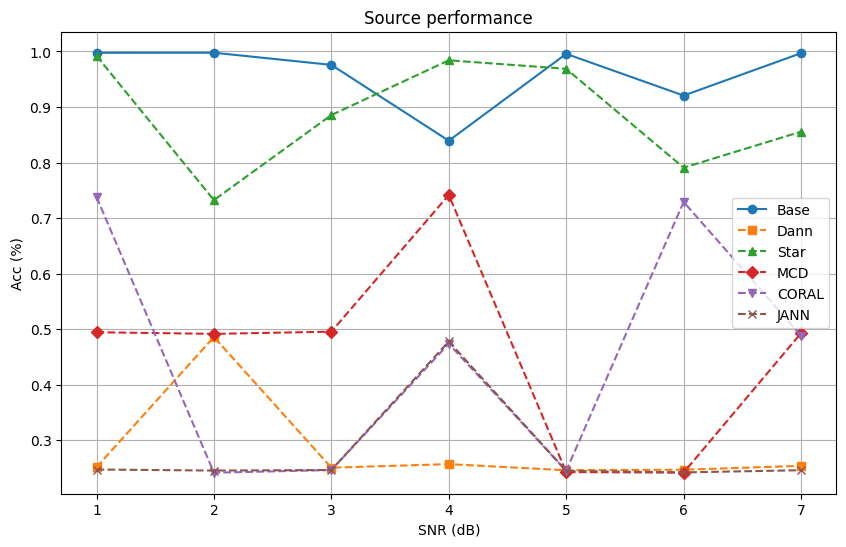

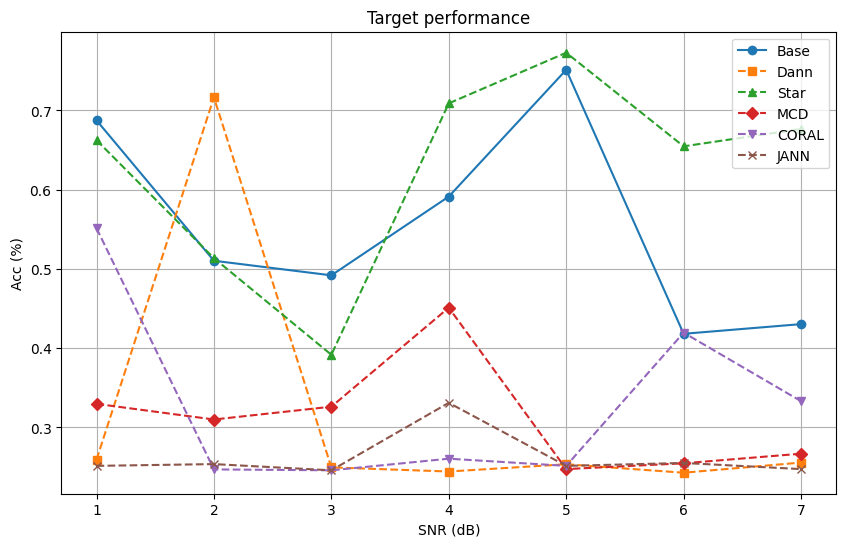

In [3]:
x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, s_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, s_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, s_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, s_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, s_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, s_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Source performance')
plt.legend()
plt.grid(True)
plt.show()


x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "16apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/sim_X.npy")
Y = np.load(file_path + "/sim_Y.npy")

sou_snr = 124
tar_snr = 110

t_base_acc = []
t_dann_acc = []
t_star_acc = []
t_mcd_acc = []
t_coral_acc = []
t_jan_acc = []

s_base_acc = []
s_dann_acc = []
s_star_acc = []
s_mcd_acc = []
s_coral_acc = []
s_jan_acc = []

n_runs = 3
lr = 0.002

for i in range(7):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    s_base, t_base = base.Base(model_cls=base.CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)
    
    s_dan, t_dan = dann.DAN(dann.DANN, FA=dann.CLDNN_FA, LP=dann.CLDNN_LP, DC=dann.CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=25, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dan)
    t_dann_acc.append(t_dan)
    
    s_star, t_star = star.Star(G=star.CLDNN_G, C=star.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)
    
    s_mcd, t_mcd = mcd.Mcd(G=mcd.CLDNN_G, C=mcd.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)
    
    s_coral, t_coral = coral.Coral(G=coral.CLDNN_G, C=coral.CLDNN_C, device=device, S_train_loader=S_train_loader,
                           S_val_loader=S_val_loader, T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                           class_subset=class_subset, n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs,
                           patience=5, lambda_coral=0.5).run()
    torch.cuda.empty_cache()
    s_coral_acc.append(s_coral)
    t_coral_acc.append(t_coral)

    s_jan, t_jan = jan.Jan(num_classes=len(class_subset), device=device, S_train_loader=S_train_loader,
                     T_train_loader=T_train_loader, S_val_loader=S_val_loader, T_val_loader=T_val_loader,
                     n_epochs=50, lr=lr, lambda_jmmd=0.1, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_jan_acc.append(s_jan)
    t_jan_acc.append(t_jan)
    
    tar_snr += 2


Run 1/3
Epoch 1/50, Train Loss: 1.4369, Train Acc: 0.2467, Val Loss: 1.3864, Val Acc: 0.2478
Epoch 2/50, Train Loss: 1.3941, Train Acc: 0.2497, Val Loss: 1.3924, Val Acc: 0.2511
Epoch 3/50, Train Loss: 1.3924, Train Acc: 0.2472, Val Loss: 1.3881, Val Acc: 0.2511
Epoch 4/50, Train Loss: 1.3882, Train Acc: 0.2581, Val Loss: 1.3866, Val Acc: 0.2591
Epoch 5/50, Train Loss: 1.3892, Train Acc: 0.2519, Val Loss: 1.3891, Val Acc: 0.2511
Epoch 6/50, Train Loss: 1.3903, Train Acc: 0.2463, Val Loss: 1.3878, Val Acc: 0.2478
Early stopping!

Run 2/3


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4128, Train Acc: 0.2500, Val Loss: 1.3915, Val Acc: 0.2591
Epoch 2/50, Train Loss: 1.3931, Train Acc: 0.2501, Val Loss: 1.3923, Val Acc: 0.2511
Epoch 3/50, Train Loss: 1.3906, Train Acc: 0.2567, Val Loss: 1.3951, Val Acc: 0.2420
Epoch 4/50, Train Loss: 1.3895, Train Acc: 0.2576, Val Loss: 1.3879, Val Acc: 0.2511
Epoch 5/50, Train Loss: 1.3890, Train Acc: 0.2549, Val Loss: 1.3892, Val Acc: 0.2420
Epoch 6/50, Train Loss: 1.3887, Train Acc: 0.2487, Val Loss: 1.3901, Val Acc: 0.2478
Epoch 7/50, Train Loss: 1.3891, Train Acc: 0.2467, Val Loss: 1.3926, Val Acc: 0.2511
Epoch 8/50, Train Loss: 1.3888, Train Acc: 0.2459, Val Loss: 1.3868, Val Acc: 0.2420
Epoch 9/50, Train Loss: 1.3873, Train Acc: 0.2518, Val Loss: 1.3867, Val Acc: 0.2478
Epoch 10/50, Train Loss: 1.3874, Train Acc: 0.2487, Val Loss: 1.3883, Val Acc: 0.2420
Epoch 11/50, Train Loss: 1.3869, Train Acc: 0.2518, Val Loss: 1.3866, Val Acc: 0.2420
Epoch 12/50, Train Loss: 1.3865, Train Acc: 0.2494, Val Loss: 1

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4109, Train Acc: 0.2490, Val Loss: 1.3868, Val Acc: 0.2591
Epoch 2/50, Train Loss: 1.3916, Train Acc: 0.2536, Val Loss: 1.3999, Val Acc: 0.2511
Epoch 3/50, Train Loss: 1.3918, Train Acc: 0.2473, Val Loss: 1.3961, Val Acc: 0.2478
Epoch 4/50, Train Loss: 1.3913, Train Acc: 0.2494, Val Loss: 1.3888, Val Acc: 0.2591
Epoch 5/50, Train Loss: 1.3886, Train Acc: 0.2489, Val Loss: 1.3868, Val Acc: 0.2591
Epoch 6/50, Train Loss: 1.3879, Train Acc: 0.2535, Val Loss: 1.3885, Val Acc: 0.2420
Epoch 7/50, Train Loss: 1.3880, Train Acc: 0.2448, Val Loss: 1.3963, Val Acc: 0.2420
Epoch 8/50, Train Loss: 1.3886, Train Acc: 0.2483, Val Loss: 1.3884, Val Acc: 0.2511
Epoch 9/50, Train Loss: 1.3883, Train Acc: 0.2470, Val Loss: 1.3873, Val Acc: 0.2478
Epoch 10/50, Train Loss: 1.3876, Train Acc: 0.2546, Val Loss: 1.3870, Val Acc: 0.2591
Early stopping!

Source performance: 24.96 6.24 25.00 9.99
Target performance: 25.04 6.26 25.00 10.01

bpsk: 0.00
qpsk: 33.33
16qam: 33.33
16apsk: 33

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.3932, Domain Loss: 1.8268, Class Loss: 1.5664
Epoch 2/25, Loss: 2.7969, Domain Loss: 1.3876, Class Loss: 1.4093
Epoch 3/25, Loss: 2.7908, Domain Loss: 1.3863, Class Loss: 1.4045
Epoch 4/25, Loss: 2.7782, Domain Loss: 1.3861, Class Loss: 1.3921
Epoch 5/25, Loss: 2.7776, Domain Loss: 1.3861, Class Loss: 1.3915
Epoch 6/25, Loss: 2.7789, Domain Loss: 1.3865, Class Loss: 1.3925
Epoch 7/25, Loss: 2.7781, Domain Loss: 1.3860, Class Loss: 1.3922
Epoch 8/25, Loss: 2.7795, Domain Loss: 1.3876, Class Loss: 1.3918
Epoch 9/25, Loss: 2.7803, Domain Loss: 1.3868, Class Loss: 1.3935
Epoch 10/25, Loss: 2.7764, Domain Loss: 1.3865, Class Loss: 1.3899
Epoch 11/25, Loss: 2.7898, Domain Loss: 1.3976, Class Loss: 1.3923
Epoch 12/25, Loss: 2.8093, Domain Loss: 1.4184, Class Loss: 1.3909
Epoch 13/25, Loss: 16.7899, Domain Loss: 14.4499, Class Loss: 2.3400
Epoch 14/25, Loss: 8.6139, Domain Loss: 7.1504, Class Loss: 1.4635
Epoch 15/25, Loss: 2.9267, Domain Loss: 1.5380, Class Loss: 1.3887
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1339, Domain Loss: 1.5223, Class Loss: 1.6117
Epoch 2/25, Loss: 2.8737, Domain Loss: 1.4656, Class Loss: 1.4082
Epoch 3/25, Loss: 5.2856, Domain Loss: 3.8550, Class Loss: 1.4306
Epoch 4/25, Loss: 18.6700, Domain Loss: 17.2660, Class Loss: 1.4040
Epoch 5/25, Loss: 7.7528, Domain Loss: 6.3564, Class Loss: 1.3964
Epoch 6/25, Loss: 3.0974, Domain Loss: 1.7053, Class Loss: 1.3921
Epoch 7/25, Loss: 2.8231, Domain Loss: 1.4311, Class Loss: 1.3920
Epoch 8/25, Loss: 2.8128, Domain Loss: 1.4229, Class Loss: 1.3899
Epoch 9/25, Loss: 2.8228, Domain Loss: 1.4348, Class Loss: 1.3880
Epoch 10/25, Loss: 2.8417, Domain Loss: 1.4534, Class Loss: 1.3883
Epoch 11/25, Loss: 2.8702, Domain Loss: 1.4809, Class Loss: 1.3893
Epoch 12/25, Loss: 2.9109, Domain Loss: 1.5220, Class Loss: 1.3889
Epoch 13/25, Loss: 2.9722, Domain Loss: 1.5838, Class Loss: 1.3884
Epoch 14/25, Loss: 3.0660, Domain Loss: 1.6757, Class Loss: 1.3903
Epoch 15/25, Loss: 3.1932, Domain Loss: 1.8042, Class Loss: 1.3890
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1538, Domain Loss: 1.5662, Class Loss: 1.5876
Epoch 2/25, Loss: 2.7799, Domain Loss: 1.3862, Class Loss: 1.3937
Epoch 3/25, Loss: 2.7794, Domain Loss: 1.3857, Class Loss: 1.3937
Epoch 4/25, Loss: 2.7795, Domain Loss: 1.3860, Class Loss: 1.3935
Epoch 5/25, Loss: 2.7786, Domain Loss: 1.3877, Class Loss: 1.3909
Epoch 6/25, Loss: 2.7898, Domain Loss: 1.3924, Class Loss: 1.3974
Epoch 7/25, Loss: 2.7956, Domain Loss: 1.4013, Class Loss: 1.3943
Epoch 8/25, Loss: 2.7881, Domain Loss: 1.3898, Class Loss: 1.3983
Epoch 9/25, Loss: 3.1655, Domain Loss: 1.7604, Class Loss: 1.4050
Epoch 10/25, Loss: 3.0719, Domain Loss: 1.6372, Class Loss: 1.4347
Epoch 11/25, Loss: 2.8084, Domain Loss: 1.4127, Class Loss: 1.3956
Epoch 12/25, Loss: 2.7948, Domain Loss: 1.4035, Class Loss: 1.3913
Epoch 13/25, Loss: 2.8003, Domain Loss: 1.4108, Class Loss: 1.3894
Epoch 14/25, Loss: 2.8102, Domain Loss: 1.4222, Class Loss: 1.3880
Epoch 15/25, Loss: 2.8246, Domain Loss: 1.4364, Class Loss: 1.3881
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 12.6310, Discrepancy Loss: 0.1086
Epoch [2/50], Class Loss: 4.0787, Discrepancy Loss: 0.2037
Epoch [3/50], Class Loss: 2.7742, Discrepancy Loss: 0.2057
Epoch [4/50], Class Loss: 2.1316, Discrepancy Loss: 0.1781
Epoch [5/50], Class Loss: 1.7740, Discrepancy Loss: 0.1403
Epoch [6/50], Class Loss: 1.5721, Discrepancy Loss: 0.1099
Epoch [7/50], Class Loss: 1.4952, Discrepancy Loss: 0.0844
Epoch [8/50], Class Loss: 1.4539, Discrepancy Loss: 0.0711
Epoch [9/50], Class Loss: 1.4370, Discrepancy Loss: 0.0629
Epoch [10/50], Class Loss: 1.4276, Discrepancy Loss: 0.0604
Epoch [11/50], Class Loss: 1.4256, Discrepancy Loss: 0.0588
Epoch [12/50], Class Loss: 1.4257, Discrepancy Loss: 0.0583
Epoch [13/50], Class Loss: 1.4224, Discrepancy Loss: 0.0583
Epoch [14/50], Class Loss: 1.4252, Discrepancy Loss: 0.0574
Epoch [15/50], Class Loss: 1.4232, Discrepancy Loss: 0.0588
Epoch [16/50], Class Loss: 1.4229, Discrepancy Loss: 0.0567
Epoch [17/50], Class Loss: 1.4228, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4325, Train Acc: 0.2582, Val Loss: 1.3870, Val Acc: 0.2490
Epoch 2/50, Train Loss: 1.3947, Train Acc: 0.2478, Val Loss: 1.4002, Val Acc: 0.2490
Epoch 3/50, Train Loss: 1.3927, Train Acc: 0.2490, Val Loss: 1.4118, Val Acc: 0.2469
Epoch 4/50, Train Loss: 1.3917, Train Acc: 0.2444, Val Loss: 1.3932, Val Acc: 0.2536
Epoch 5/50, Train Loss: 1.3896, Train Acc: 0.2500, Val Loss: 1.3865, Val Acc: 0.2505
Epoch 6/50, Train Loss: 1.3886, Train Acc: 0.2589, Val Loss: 1.3886, Val Acc: 0.2490
Epoch 7/50, Train Loss: 1.3881, Train Acc: 0.2502, Val Loss: 1.3870, Val Acc: 0.2469
Epoch 8/50, Train Loss: 1.3881, Train Acc: 0.2486, Val Loss: 1.3875, Val Acc: 0.2490
Epoch 9/50, Train Loss: 1.3877, Train Acc: 0.2493, Val Loss: 1.3872, Val Acc: 0.2469
Epoch 10/50, Train Loss: 1.3883, Train Acc: 0.2474, Val Loss: 1.3874, Val Acc: 0.2505
Early stopping!

Run 3/3


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4406, Train Acc: 0.2476, Val Loss: 1.3947, Val Acc: 0.2505
Epoch 2/50, Train Loss: 1.3937, Train Acc: 0.2570, Val Loss: 1.3995, Val Acc: 0.2505
Epoch 3/50, Train Loss: 1.3913, Train Acc: 0.2531, Val Loss: 1.3881, Val Acc: 0.2536
Epoch 4/50, Train Loss: 1.3903, Train Acc: 0.2560, Val Loss: 1.3875, Val Acc: 0.2505
Epoch 5/50, Train Loss: 1.3892, Train Acc: 0.2452, Val Loss: 1.3892, Val Acc: 0.2469
Epoch 6/50, Train Loss: 1.3891, Train Acc: 0.2438, Val Loss: 1.3875, Val Acc: 0.2490
Epoch 7/50, Train Loss: 1.3891, Train Acc: 0.2473, Val Loss: 1.3887, Val Acc: 0.2490
Epoch 8/50, Train Loss: 1.3889, Train Acc: 0.2451, Val Loss: 1.3884, Val Acc: 0.2469
Epoch 9/50, Train Loss: 1.3882, Train Acc: 0.2519, Val Loss: 1.3876, Val Acc: 0.2505
Epoch 10/50, Train Loss: 1.3879, Train Acc: 0.2567, Val Loss: 1.3881, Val Acc: 0.2383
Epoch 11/50, Train Loss: 1.3871, Train Acc: 0.2473, Val Loss: 1.3864, Val Acc: 0.2536
Epoch 12/50, Train Loss: 1.3867, Train Acc: 0.2495, Val Loss: 1

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0287, Domain Loss: 1.5389, Class Loss: 1.4898
Epoch 2/25, Loss: 2.7911, Domain Loss: 1.3867, Class Loss: 1.4043
Epoch 3/25, Loss: 2.7753, Domain Loss: 1.3863, Class Loss: 1.3889
Epoch 4/25, Loss: 2.7765, Domain Loss: 1.3863, Class Loss: 1.3902
Epoch 5/25, Loss: 2.7774, Domain Loss: 1.3862, Class Loss: 1.3912
Epoch 6/25, Loss: 2.7776, Domain Loss: 1.3863, Class Loss: 1.3914
Epoch 7/25, Loss: 2.7771, Domain Loss: 1.3867, Class Loss: 1.3904
Epoch 8/25, Loss: 2.7764, Domain Loss: 1.3863, Class Loss: 1.3901
Epoch 9/25, Loss: 2.7765, Domain Loss: 1.3858, Class Loss: 1.3907
Epoch 10/25, Loss: 2.7777, Domain Loss: 1.3862, Class Loss: 1.3915
Epoch 11/25, Loss: 2.7784, Domain Loss: 1.3867, Class Loss: 1.3917
Epoch 12/25, Loss: 2.7785, Domain Loss: 1.3867, Class Loss: 1.3918
Epoch 13/25, Loss: 2.7736, Domain Loss: 1.3863, Class Loss: 1.3873
Epoch 14/25, Loss: 2.7757, Domain Loss: 1.3860, Class Loss: 1.3897
Epoch 15/25, Loss: 2.7791, Domain Loss: 1.3866, Class Loss: 1.3925
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1175, Domain Loss: 1.5869, Class Loss: 1.5306
Epoch 2/25, Loss: 2.7794, Domain Loss: 1.3865, Class Loss: 1.3929
Epoch 3/25, Loss: 2.7798, Domain Loss: 1.3862, Class Loss: 1.3936
Epoch 4/25, Loss: 2.8000, Domain Loss: 1.4085, Class Loss: 1.3916
Epoch 5/25, Loss: 3.5128, Domain Loss: 2.0651, Class Loss: 1.4476
Epoch 6/25, Loss: 3.1216, Domain Loss: 1.7242, Class Loss: 1.3974
Epoch 7/25, Loss: 2.8113, Domain Loss: 1.4192, Class Loss: 1.3921
Epoch 8/25, Loss: 2.7821, Domain Loss: 1.3928, Class Loss: 1.3893
Epoch 9/25, Loss: 2.7815, Domain Loss: 1.3924, Class Loss: 1.3891
Epoch 10/25, Loss: 2.8158, Domain Loss: 1.4278, Class Loss: 1.3880
Epoch 11/25, Loss: 2.8357, Domain Loss: 1.4473, Class Loss: 1.3884
Epoch 12/25, Loss: 2.8419, Domain Loss: 1.4537, Class Loss: 1.3881
Epoch 13/25, Loss: 2.8305, Domain Loss: 1.4411, Class Loss: 1.3894
Epoch 14/25, Loss: 2.8262, Domain Loss: 1.4368, Class Loss: 1.3894
Epoch 15/25, Loss: 2.8338, Domain Loss: 1.4445, Class Loss: 1.3893
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.3235, Domain Loss: 1.7994, Class Loss: 1.5241
Epoch 2/25, Loss: 2.7788, Domain Loss: 1.3879, Class Loss: 1.3909
Epoch 3/25, Loss: 2.7863, Domain Loss: 1.3883, Class Loss: 1.3980
Epoch 4/25, Loss: 2.7797, Domain Loss: 1.3893, Class Loss: 1.3904
Epoch 5/25, Loss: 2.7830, Domain Loss: 1.3923, Class Loss: 1.3906
Epoch 6/25, Loss: 2.8030, Domain Loss: 1.4015, Class Loss: 1.4016
Epoch 7/25, Loss: 2.8076, Domain Loss: 1.4061, Class Loss: 1.4015
Epoch 8/25, Loss: 2.8001, Domain Loss: 1.4070, Class Loss: 1.3931
Epoch 9/25, Loss: 2.8138, Domain Loss: 1.4169, Class Loss: 1.3970
Epoch 10/25, Loss: 3.6983, Domain Loss: 2.3035, Class Loss: 1.3948
Epoch 11/25, Loss: 2.9974, Domain Loss: 1.6056, Class Loss: 1.3918
Epoch 12/25, Loss: 2.7892, Domain Loss: 1.3999, Class Loss: 1.3893
Epoch 13/25, Loss: 2.7785, Domain Loss: 1.3892, Class Loss: 1.3893
Epoch 14/25, Loss: 2.7787, Domain Loss: 1.3891, Class Loss: 1.3897
Epoch 15/25, Loss: 2.7773, Domain Loss: 1.3894, Class Loss: 1.3879
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 13.8022, Discrepancy Loss: 0.0969
Epoch [2/50], Class Loss: 4.6708, Discrepancy Loss: 0.1881
Epoch [3/50], Class Loss: 2.7434, Discrepancy Loss: 0.2099
Epoch [4/50], Class Loss: 2.1618, Discrepancy Loss: 0.1794
Epoch [5/50], Class Loss: 1.7696, Discrepancy Loss: 0.1462
Epoch [6/50], Class Loss: 1.6030, Discrepancy Loss: 0.1119
Epoch [7/50], Class Loss: 1.5000, Discrepancy Loss: 0.0880
Epoch [8/50], Class Loss: 1.4641, Discrepancy Loss: 0.0725
Epoch [9/50], Class Loss: 1.4432, Discrepancy Loss: 0.0635
Epoch [10/50], Class Loss: 1.4284, Discrepancy Loss: 0.0591
Epoch [11/50], Class Loss: 1.4297, Discrepancy Loss: 0.0589
Epoch [12/50], Class Loss: 1.4262, Discrepancy Loss: 0.0576
Epoch [13/50], Class Loss: 1.4246, Discrepancy Loss: 0.0571
Epoch [14/50], Class Loss: 1.4235, Discrepancy Loss: 0.0576
Epoch [15/50], Class Loss: 1.4243, Discrepancy Loss: 0.0574
Epoch [16/50], Class Loss: 1.4215, Discrepancy Loss: 0.0564
Epoch [17/50], Class Loss: 1.4216, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4427, Train Acc: 0.2450, Val Loss: 1.3914, Val Acc: 0.2539
Epoch 2/50, Train Loss: 1.3962, Train Acc: 0.2498, Val Loss: 1.3904, Val Acc: 0.2399
Epoch 3/50, Train Loss: 1.3918, Train Acc: 0.2477, Val Loss: 1.4059, Val Acc: 0.2399
Epoch 4/50, Train Loss: 1.3895, Train Acc: 0.2504, Val Loss: 1.3892, Val Acc: 0.2539
Epoch 5/50, Train Loss: 1.3886, Train Acc: 0.2464, Val Loss: 1.3881, Val Acc: 0.2481
Epoch 6/50, Train Loss: 1.3891, Train Acc: 0.2511, Val Loss: 1.3895, Val Acc: 0.2481
Epoch 7/50, Train Loss: 1.3888, Train Acc: 0.2461, Val Loss: 1.3905, Val Acc: 0.2399
Epoch 8/50, Train Loss: 1.3883, Train Acc: 0.2478, Val Loss: 1.3882, Val Acc: 0.2481
Epoch 9/50, Train Loss: 1.3889, Train Acc: 0.2538, Val Loss: 1.3876, Val Acc: 0.2582
Epoch 10/50, Train Loss: 1.3879, Train Acc: 0.2545, Val Loss: 1.3867, Val Acc: 0.2582
Epoch 11/50, Train Loss: 1.3871, Train Acc: 0.2490, Val Loss: 1.3867, Val Acc: 0.2481
Epoch 12/50, Train Loss: 1.3864, Train Acc: 0.2497, Val Loss: 1

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4221, Train Acc: 0.2503, Val Loss: 1.3950, Val Acc: 0.2399
Epoch 2/50, Train Loss: 1.3939, Train Acc: 0.2497, Val Loss: 1.3872, Val Acc: 0.2481
Epoch 3/50, Train Loss: 1.3921, Train Acc: 0.2480, Val Loss: 1.3922, Val Acc: 0.2539
Epoch 4/50, Train Loss: 1.3913, Train Acc: 0.2486, Val Loss: 1.3910, Val Acc: 0.2399
Epoch 5/50, Train Loss: 1.3894, Train Acc: 0.2587, Val Loss: 1.3866, Val Acc: 0.2582
Epoch 6/50, Train Loss: 1.3883, Train Acc: 0.2453, Val Loss: 1.3875, Val Acc: 0.2481
Epoch 7/50, Train Loss: 1.3877, Train Acc: 0.2517, Val Loss: 1.3883, Val Acc: 0.2399
Epoch 8/50, Train Loss: 1.3882, Train Acc: 0.2441, Val Loss: 1.3872, Val Acc: 0.2399
Epoch 9/50, Train Loss: 1.3875, Train Acc: 0.2527, Val Loss: 1.3911, Val Acc: 0.2399
Epoch 10/50, Train Loss: 1.3877, Train Acc: 0.2499, Val Loss: 1.3898, Val Acc: 0.2399
Early stopping!

Source performance: 23.99 6.00 25.00 9.67
Target performance: 25.82 6.45 25.00 10.26

bpsk: 100.00
qpsk: 0.00
16qam: 0.00
16apsk: 0.

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.3245, Domain Loss: 1.8099, Class Loss: 1.5146
Epoch 2/25, Loss: 2.7851, Domain Loss: 1.3887, Class Loss: 1.3965
Epoch 3/25, Loss: 2.7806, Domain Loss: 1.3870, Class Loss: 1.3937
Epoch 4/25, Loss: 2.7927, Domain Loss: 1.3931, Class Loss: 1.3995
Epoch 5/25, Loss: 2.7921, Domain Loss: 1.3998, Class Loss: 1.3923
Epoch 6/25, Loss: 2.7988, Domain Loss: 1.4058, Class Loss: 1.3929
Epoch 7/25, Loss: 2.8115, Domain Loss: 1.4186, Class Loss: 1.3929
Epoch 8/25, Loss: 2.7924, Domain Loss: 1.4008, Class Loss: 1.3916
Epoch 9/25, Loss: 2.7844, Domain Loss: 1.3939, Class Loss: 1.3906
Epoch 10/25, Loss: 2.7828, Domain Loss: 1.3941, Class Loss: 1.3887
Epoch 11/25, Loss: 2.7856, Domain Loss: 1.3933, Class Loss: 1.3922
Epoch 12/25, Loss: 2.7729, Domain Loss: 1.3837, Class Loss: 1.3893
Epoch 13/25, Loss: 2.7811, Domain Loss: 1.3905, Class Loss: 1.3906
Epoch 14/25, Loss: 2.7706, Domain Loss: 1.3813, Class Loss: 1.3893
Epoch 15/25, Loss: 2.7796, Domain Loss: 1.3902, Class Loss: 1.3894
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0672, Domain Loss: 1.5701, Class Loss: 1.4971
Epoch 2/25, Loss: 2.7929, Domain Loss: 1.3865, Class Loss: 1.4064
Epoch 3/25, Loss: 2.7822, Domain Loss: 1.3868, Class Loss: 1.3954
Epoch 4/25, Loss: 2.7794, Domain Loss: 1.3864, Class Loss: 1.3931
Epoch 5/25, Loss: 2.7799, Domain Loss: 1.3863, Class Loss: 1.3936
Epoch 6/25, Loss: 2.7789, Domain Loss: 1.3863, Class Loss: 1.3927
Epoch 7/25, Loss: 2.7837, Domain Loss: 1.3863, Class Loss: 1.3973
Epoch 8/25, Loss: 2.7784, Domain Loss: 1.3864, Class Loss: 1.3921
Epoch 9/25, Loss: 2.7791, Domain Loss: 1.3864, Class Loss: 1.3927
Epoch 10/25, Loss: 2.7786, Domain Loss: 1.3862, Class Loss: 1.3923
Epoch 11/25, Loss: 2.7794, Domain Loss: 1.3862, Class Loss: 1.3932
Epoch 12/25, Loss: 2.7764, Domain Loss: 1.3867, Class Loss: 1.3897
Epoch 13/25, Loss: 2.7761, Domain Loss: 1.3876, Class Loss: 1.3884
Epoch 14/25, Loss: 2.7776, Domain Loss: 1.3859, Class Loss: 1.3917
Epoch 15/25, Loss: 2.7774, Domain Loss: 1.3860, Class Loss: 1.3914
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1321, Domain Loss: 1.5487, Class Loss: 1.5833
Epoch 2/25, Loss: 2.7953, Domain Loss: 1.3870, Class Loss: 1.4083
Epoch 3/25, Loss: 2.7802, Domain Loss: 1.3865, Class Loss: 1.3937
Epoch 4/25, Loss: 2.7800, Domain Loss: 1.3864, Class Loss: 1.3935
Epoch 5/25, Loss: 2.7782, Domain Loss: 1.3864, Class Loss: 1.3918
Epoch 6/25, Loss: 2.7766, Domain Loss: 1.3863, Class Loss: 1.3903
Epoch 7/25, Loss: 2.7788, Domain Loss: 1.3863, Class Loss: 1.3925
Epoch 8/25, Loss: 2.7791, Domain Loss: 1.3863, Class Loss: 1.3928
Epoch 9/25, Loss: 2.7777, Domain Loss: 1.3863, Class Loss: 1.3913
Epoch 10/25, Loss: 2.7769, Domain Loss: 1.3863, Class Loss: 1.3906
Epoch 11/25, Loss: 2.7770, Domain Loss: 1.3864, Class Loss: 1.3905
Epoch 12/25, Loss: 2.7780, Domain Loss: 1.3870, Class Loss: 1.3910
Epoch 13/25, Loss: 2.7752, Domain Loss: 1.3857, Class Loss: 1.3894
Epoch 14/25, Loss: 2.7736, Domain Loss: 1.3848, Class Loss: 1.3889
Epoch 15/25, Loss: 3.4731, Domain Loss: 2.0416, Class Loss: 1.4315
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 12.5420, Discrepancy Loss: 0.1127
Epoch [2/50], Class Loss: 3.9981, Discrepancy Loss: 0.2162
Epoch [3/50], Class Loss: 2.8392, Discrepancy Loss: 0.2100
Epoch [4/50], Class Loss: 2.2068, Discrepancy Loss: 0.1843
Epoch [5/50], Class Loss: 1.8223, Discrepancy Loss: 0.1493
Epoch [6/50], Class Loss: 1.6103, Discrepancy Loss: 0.1124
Epoch [7/50], Class Loss: 1.5099, Discrepancy Loss: 0.0886
Epoch [8/50], Class Loss: 1.4662, Discrepancy Loss: 0.0746
Epoch [9/50], Class Loss: 1.4424, Discrepancy Loss: 0.0637
Epoch [10/50], Class Loss: 1.4282, Discrepancy Loss: 0.0589
Epoch [11/50], Class Loss: 1.4200, Discrepancy Loss: 0.0577
Epoch [12/50], Class Loss: 1.4226, Discrepancy Loss: 0.0568
Epoch [13/50], Class Loss: 1.4257, Discrepancy Loss: 0.0571
Epoch [14/50], Class Loss: 1.4266, Discrepancy Loss: 0.0563
Epoch [15/50], Class Loss: 1.4248, Discrepancy Loss: 0.0558
Epoch [16/50], Class Loss: 1.4223, Discrepancy Loss: 0.0557
Epoch [17/50], Class Loss: 1.4235, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4237, Train Acc: 0.2498, Val Loss: 1.3908, Val Acc: 0.2524
Epoch 2/50, Train Loss: 1.3949, Train Acc: 0.2493, Val Loss: 1.3909, Val Acc: 0.2524
Epoch 3/50, Train Loss: 1.3923, Train Acc: 0.2506, Val Loss: 1.3867, Val Acc: 0.2502
Epoch 4/50, Train Loss: 1.3891, Train Acc: 0.2531, Val Loss: 1.3903, Val Acc: 0.2545
Epoch 5/50, Train Loss: 1.3899, Train Acc: 0.2404, Val Loss: 1.3886, Val Acc: 0.2524
Epoch 6/50, Train Loss: 1.3891, Train Acc: 0.2499, Val Loss: 1.3898, Val Acc: 0.2545
Epoch 7/50, Train Loss: 1.3882, Train Acc: 0.2517, Val Loss: 1.3883, Val Acc: 0.2545
Epoch 8/50, Train Loss: 1.3882, Train Acc: 0.2519, Val Loss: 1.3881, Val Acc: 0.2545
Early stopping!

Run 3/3


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4315, Train Acc: 0.2523, Val Loss: 1.3923, Val Acc: 0.2502
Epoch 2/50, Train Loss: 1.3921, Train Acc: 0.2496, Val Loss: 1.3940, Val Acc: 0.2429
Epoch 3/50, Train Loss: 1.3910, Train Acc: 0.2488, Val Loss: 1.3948, Val Acc: 0.2429
Epoch 4/50, Train Loss: 1.3899, Train Acc: 0.2500, Val Loss: 1.3882, Val Acc: 0.2524
Epoch 5/50, Train Loss: 1.3901, Train Acc: 0.2607, Val Loss: 1.3880, Val Acc: 0.2502
Epoch 6/50, Train Loss: 1.3881, Train Acc: 0.2486, Val Loss: 1.3879, Val Acc: 0.2545
Epoch 7/50, Train Loss: 1.3880, Train Acc: 0.2520, Val Loss: 1.3877, Val Acc: 0.2524
Epoch 8/50, Train Loss: 1.3882, Train Acc: 0.2484, Val Loss: 1.3873, Val Acc: 0.2524
Epoch 9/50, Train Loss: 1.3884, Train Acc: 0.2502, Val Loss: 1.3872, Val Acc: 0.2502
Epoch 10/50, Train Loss: 1.3873, Train Acc: 0.2502, Val Loss: 1.3873, Val Acc: 0.2429
Epoch 11/50, Train Loss: 1.3866, Train Acc: 0.2506, Val Loss: 1.3863, Val Acc: 0.2545
Epoch 12/50, Train Loss: 1.3864, Train Acc: 0.2515, Val Loss: 1

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1183, Domain Loss: 1.5690, Class Loss: 1.5493
Epoch 2/25, Loss: 2.7829, Domain Loss: 1.3865, Class Loss: 1.3964
Epoch 3/25, Loss: 2.7832, Domain Loss: 1.3872, Class Loss: 1.3960
Epoch 4/25, Loss: 2.7779, Domain Loss: 1.3865, Class Loss: 1.3915
Epoch 5/25, Loss: 2.7788, Domain Loss: 1.3863, Class Loss: 1.3925
Epoch 6/25, Loss: 2.7783, Domain Loss: 1.3863, Class Loss: 1.3920
Epoch 7/25, Loss: 2.7764, Domain Loss: 1.3863, Class Loss: 1.3901
Epoch 8/25, Loss: 2.7813, Domain Loss: 1.3863, Class Loss: 1.3949
Epoch 9/25, Loss: 2.7792, Domain Loss: 1.3863, Class Loss: 1.3929
Epoch 10/25, Loss: 2.7781, Domain Loss: 1.3863, Class Loss: 1.3918
Epoch 11/25, Loss: 2.7753, Domain Loss: 1.3863, Class Loss: 1.3890
Epoch 12/25, Loss: 2.7769, Domain Loss: 1.3863, Class Loss: 1.3906
Epoch 13/25, Loss: 2.7760, Domain Loss: 1.3863, Class Loss: 1.3896
Epoch 14/25, Loss: 2.7752, Domain Loss: 1.3863, Class Loss: 1.3888
Epoch 15/25, Loss: 2.7746, Domain Loss: 1.3863, Class Loss: 1.3883
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.2585, Domain Loss: 1.7079, Class Loss: 1.5506
Epoch 2/25, Loss: 2.7788, Domain Loss: 1.3866, Class Loss: 1.3921
Epoch 3/25, Loss: 2.7828, Domain Loss: 1.3863, Class Loss: 1.3965
Epoch 4/25, Loss: 2.7806, Domain Loss: 1.3863, Class Loss: 1.3943
Epoch 5/25, Loss: 2.7784, Domain Loss: 1.3863, Class Loss: 1.3920
Epoch 6/25, Loss: 2.7817, Domain Loss: 1.3889, Class Loss: 1.3928
Epoch 7/25, Loss: 2.7799, Domain Loss: 1.3868, Class Loss: 1.3931
Epoch 8/25, Loss: 2.7806, Domain Loss: 1.3864, Class Loss: 1.3943
Epoch 9/25, Loss: 2.7788, Domain Loss: 1.3864, Class Loss: 1.3924
Epoch 10/25, Loss: 2.7788, Domain Loss: 1.3864, Class Loss: 1.3924
Epoch 11/25, Loss: 2.7794, Domain Loss: 1.3863, Class Loss: 1.3931
Epoch 12/25, Loss: 2.7758, Domain Loss: 1.3863, Class Loss: 1.3895
Epoch 13/25, Loss: 2.7779, Domain Loss: 1.3863, Class Loss: 1.3916
Epoch 14/25, Loss: 2.7774, Domain Loss: 1.3863, Class Loss: 1.3911
Epoch 15/25, Loss: 2.7760, Domain Loss: 1.3863, Class Loss: 1.3897
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0337, Domain Loss: 1.5645, Class Loss: 1.4693
Epoch 2/25, Loss: 2.7798, Domain Loss: 1.3866, Class Loss: 1.3932
Epoch 3/25, Loss: 2.7821, Domain Loss: 1.3863, Class Loss: 1.3958
Epoch 4/25, Loss: 2.7840, Domain Loss: 1.3863, Class Loss: 1.3977
Epoch 5/25, Loss: 2.7810, Domain Loss: 1.3863, Class Loss: 1.3947
Epoch 6/25, Loss: 2.7782, Domain Loss: 1.3863, Class Loss: 1.3919
Epoch 7/25, Loss: 2.7781, Domain Loss: 1.3897, Class Loss: 1.3884
Epoch 8/25, Loss: 2.7760, Domain Loss: 1.3873, Class Loss: 1.3887
Epoch 9/25, Loss: 2.7755, Domain Loss: 1.3864, Class Loss: 1.3892
Epoch 10/25, Loss: 2.7764, Domain Loss: 1.3863, Class Loss: 1.3901
Epoch 11/25, Loss: 2.7761, Domain Loss: 1.3863, Class Loss: 1.3898
Epoch 12/25, Loss: 2.7801, Domain Loss: 1.3868, Class Loss: 1.3933
Epoch 13/25, Loss: 2.7984, Domain Loss: 1.4038, Class Loss: 1.3946
Epoch 14/25, Loss: 3.0098, Domain Loss: 1.6168, Class Loss: 1.3930
Epoch 15/25, Loss: 2.7800, Domain Loss: 1.3904, Class Loss: 1.3896
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 12.9375, Discrepancy Loss: 0.1082
Epoch [2/50], Class Loss: 4.1505, Discrepancy Loss: 0.2079
Epoch [3/50], Class Loss: 2.8427, Discrepancy Loss: 0.2027
Epoch [4/50], Class Loss: 2.1785, Discrepancy Loss: 0.1778
Epoch [5/50], Class Loss: 1.7778, Discrepancy Loss: 0.1415
Epoch [6/50], Class Loss: 1.5950, Discrepancy Loss: 0.1087
Epoch [7/50], Class Loss: 1.4977, Discrepancy Loss: 0.0858
Epoch [8/50], Class Loss: 1.4547, Discrepancy Loss: 0.0725
Epoch [9/50], Class Loss: 1.4402, Discrepancy Loss: 0.0658
Epoch [10/50], Class Loss: 1.4284, Discrepancy Loss: 0.0630
Epoch [11/50], Class Loss: 1.4283, Discrepancy Loss: 0.0617
Epoch [12/50], Class Loss: 1.4303, Discrepancy Loss: 0.0609
Epoch [13/50], Class Loss: 1.4268, Discrepancy Loss: 0.0612
Epoch [14/50], Class Loss: 1.4284, Discrepancy Loss: 0.0604
Epoch [15/50], Class Loss: 1.4246, Discrepancy Loss: 0.0600
Epoch [16/50], Class Loss: 1.4215, Discrepancy Loss: 0.0590
Epoch [17/50], Class Loss: 1.4229, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4384, Train Acc: 0.2473, Val Loss: 1.3866, Val Acc: 0.2624
Epoch 2/50, Train Loss: 1.3939, Train Acc: 0.2412, Val Loss: 1.3900, Val Acc: 0.2460
Epoch 3/50, Train Loss: 1.3947, Train Acc: 0.2470, Val Loss: 1.3868, Val Acc: 0.2624
Epoch 4/50, Train Loss: 1.3898, Train Acc: 0.2509, Val Loss: 1.3869, Val Acc: 0.2469
Epoch 5/50, Train Loss: 1.3893, Train Acc: 0.2473, Val Loss: 1.3886, Val Acc: 0.2447
Epoch 6/50, Train Loss: 1.3886, Train Acc: 0.2546, Val Loss: 1.3879, Val Acc: 0.2447
Early stopping!

Run 3/3


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4178, Train Acc: 0.2460, Val Loss: 1.3996, Val Acc: 0.2460
Epoch 2/50, Train Loss: 1.3935, Train Acc: 0.2430, Val Loss: 1.3896, Val Acc: 0.2460
Epoch 3/50, Train Loss: 1.3905, Train Acc: 0.2464, Val Loss: 1.3893, Val Acc: 0.2469
Epoch 4/50, Train Loss: 1.3904, Train Acc: 0.2558, Val Loss: 1.3882, Val Acc: 0.2624
Epoch 5/50, Train Loss: 1.3898, Train Acc: 0.2531, Val Loss: 1.3889, Val Acc: 0.2469
Epoch 6/50, Train Loss: 1.3883, Train Acc: 0.2487, Val Loss: 1.3886, Val Acc: 0.2460
Epoch 7/50, Train Loss: 1.3881, Train Acc: 0.2516, Val Loss: 1.3954, Val Acc: 0.2469
Epoch 8/50, Train Loss: 1.3886, Train Acc: 0.2454, Val Loss: 1.3874, Val Acc: 0.2460
Epoch 9/50, Train Loss: 1.3880, Train Acc: 0.2440, Val Loss: 1.3867, Val Acc: 0.2460
Epoch 10/50, Train Loss: 1.3872, Train Acc: 0.2556, Val Loss: 1.3892, Val Acc: 0.2447
Epoch 11/50, Train Loss: 1.3870, Train Acc: 0.2464, Val Loss: 1.3866, Val Acc: 0.2447
Epoch 12/50, Train Loss: 1.3866, Train Acc: 0.2445, Val Loss: 1

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.3463, Domain Loss: 1.8573, Class Loss: 1.4890
Epoch 2/25, Loss: 2.7935, Domain Loss: 1.3899, Class Loss: 1.4036
Epoch 3/25, Loss: 2.7810, Domain Loss: 1.3896, Class Loss: 1.3914
Epoch 4/25, Loss: 2.7822, Domain Loss: 1.3879, Class Loss: 1.3943
Epoch 5/25, Loss: 2.7828, Domain Loss: 1.3874, Class Loss: 1.3954
Epoch 6/25, Loss: 2.7861, Domain Loss: 1.3875, Class Loss: 1.3986
Epoch 7/25, Loss: 3.4020, Domain Loss: 2.0055, Class Loss: 1.3965
Epoch 8/25, Loss: 3.7763, Domain Loss: 2.3822, Class Loss: 1.3942
Epoch 9/25, Loss: 2.8115, Domain Loss: 1.4214, Class Loss: 1.3901
Epoch 10/25, Loss: 2.7784, Domain Loss: 1.3884, Class Loss: 1.3900
Epoch 11/25, Loss: 2.7758, Domain Loss: 1.3865, Class Loss: 1.3893
Epoch 12/25, Loss: 2.7753, Domain Loss: 1.3864, Class Loss: 1.3890
Epoch 13/25, Loss: 2.7751, Domain Loss: 1.3864, Class Loss: 1.3887
Epoch 14/25, Loss: 2.7751, Domain Loss: 1.3864, Class Loss: 1.3887
Epoch 15/25, Loss: 2.7755, Domain Loss: 1.3864, Class Loss: 1.3891
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.2883, Domain Loss: 1.6855, Class Loss: 1.6028
Epoch 2/25, Loss: 2.7781, Domain Loss: 1.3879, Class Loss: 1.3902
Epoch 3/25, Loss: 2.7846, Domain Loss: 1.3864, Class Loss: 1.3981
Epoch 4/25, Loss: 2.7796, Domain Loss: 1.3869, Class Loss: 1.3927
Epoch 5/25, Loss: 2.7761, Domain Loss: 1.3866, Class Loss: 1.3895
Epoch 6/25, Loss: 2.7775, Domain Loss: 1.3864, Class Loss: 1.3911
Epoch 7/25, Loss: 2.7774, Domain Loss: 1.3864, Class Loss: 1.3910
Epoch 8/25, Loss: 2.7814, Domain Loss: 1.3864, Class Loss: 1.3950
Epoch 9/25, Loss: 2.7832, Domain Loss: 1.3865, Class Loss: 1.3967
Epoch 10/25, Loss: 2.7782, Domain Loss: 1.3864, Class Loss: 1.3918
Epoch 11/25, Loss: 2.7771, Domain Loss: 1.3864, Class Loss: 1.3907
Epoch 12/25, Loss: 2.7780, Domain Loss: 1.3863, Class Loss: 1.3916
Epoch 13/25, Loss: 2.7763, Domain Loss: 1.3863, Class Loss: 1.3900
Epoch 14/25, Loss: 2.7745, Domain Loss: 1.3863, Class Loss: 1.3881
Epoch 15/25, Loss: 2.7744, Domain Loss: 1.3863, Class Loss: 1.3880
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1702, Domain Loss: 1.6351, Class Loss: 1.5351
Epoch 2/25, Loss: 2.7855, Domain Loss: 1.3875, Class Loss: 1.3980
Epoch 3/25, Loss: 2.7811, Domain Loss: 1.3865, Class Loss: 1.3946
Epoch 4/25, Loss: 2.7807, Domain Loss: 1.3864, Class Loss: 1.3944
Epoch 5/25, Loss: 2.7777, Domain Loss: 1.3864, Class Loss: 1.3913
Epoch 6/25, Loss: 2.7828, Domain Loss: 1.3864, Class Loss: 1.3964
Epoch 7/25, Loss: 2.7798, Domain Loss: 1.3864, Class Loss: 1.3934
Epoch 8/25, Loss: 2.7762, Domain Loss: 1.3864, Class Loss: 1.3897
Epoch 9/25, Loss: 2.7808, Domain Loss: 1.3864, Class Loss: 1.3944
Epoch 10/25, Loss: 2.7762, Domain Loss: 1.3864, Class Loss: 1.3898
Epoch 11/25, Loss: 2.7781, Domain Loss: 1.3863, Class Loss: 1.3918
Epoch 12/25, Loss: 2.7758, Domain Loss: 1.3863, Class Loss: 1.3895
Epoch 13/25, Loss: 2.7749, Domain Loss: 1.3863, Class Loss: 1.3886
Epoch 14/25, Loss: 2.7777, Domain Loss: 1.3863, Class Loss: 1.3913
Epoch 15/25, Loss: 2.7766, Domain Loss: 1.3863, Class Loss: 1.3903
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 12.6927, Discrepancy Loss: 0.1129
Epoch [2/50], Class Loss: 4.2455, Discrepancy Loss: 0.2126
Epoch [3/50], Class Loss: 2.9723, Discrepancy Loss: 0.2024
Epoch [4/50], Class Loss: 2.2838, Discrepancy Loss: 0.1830
Epoch [5/50], Class Loss: 1.8617, Discrepancy Loss: 0.1483
Epoch [6/50], Class Loss: 1.6258, Discrepancy Loss: 0.1147
Epoch [7/50], Class Loss: 1.5078, Discrepancy Loss: 0.0890
Epoch [8/50], Class Loss: 1.4615, Discrepancy Loss: 0.0726
Epoch [9/50], Class Loss: 1.4454, Discrepancy Loss: 0.0631
Epoch [10/50], Class Loss: 1.4320, Discrepancy Loss: 0.0575
Epoch [11/50], Class Loss: 1.4249, Discrepancy Loss: 0.0557
Epoch [12/50], Class Loss: 1.4282, Discrepancy Loss: 0.0554
Epoch [13/50], Class Loss: 1.4235, Discrepancy Loss: 0.0554
Epoch [14/50], Class Loss: 1.4248, Discrepancy Loss: 0.0555
Epoch [15/50], Class Loss: 1.4207, Discrepancy Loss: 0.0551
Epoch [16/50], Class Loss: 1.4234, Discrepancy Loss: 0.0551
Epoch [17/50], Class Loss: 1.4243, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4195, Train Acc: 0.2454, Val Loss: 1.3876, Val Acc: 0.2569
Epoch 2/50, Train Loss: 1.3935, Train Acc: 0.2482, Val Loss: 1.3898, Val Acc: 0.2453
Epoch 3/50, Train Loss: 1.3910, Train Acc: 0.2566, Val Loss: 1.3921, Val Acc: 0.2475
Epoch 4/50, Train Loss: 1.3888, Train Acc: 0.2524, Val Loss: 1.3915, Val Acc: 0.2475
Epoch 5/50, Train Loss: 1.3885, Train Acc: 0.2461, Val Loss: 1.3874, Val Acc: 0.2453
Epoch 6/50, Train Loss: 1.3881, Train Acc: 0.2547, Val Loss: 1.3900, Val Acc: 0.2475
Epoch 7/50, Train Loss: 1.3889, Train Acc: 0.2470, Val Loss: 1.3866, Val Acc: 0.2475
Epoch 8/50, Train Loss: 1.3883, Train Acc: 0.2515, Val Loss: 1.3872, Val Acc: 0.2502
Epoch 9/50, Train Loss: 1.3875, Train Acc: 0.2515, Val Loss: 1.3871, Val Acc: 0.2502
Epoch 10/50, Train Loss: 1.3878, Train Acc: 0.2464, Val Loss: 1.3880, Val Acc: 0.2475
Epoch 11/50, Train Loss: 1.3868, Train Acc: 0.2469, Val Loss: 1.3864, Val Acc: 0.2453
Epoch 12/50, Train Loss: 1.3866, Train Acc: 0.2490, Val Loss: 1

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4186, Train Acc: 0.2514, Val Loss: 1.3977, Val Acc: 0.2502
Epoch 2/50, Train Loss: 1.3955, Train Acc: 0.2504, Val Loss: 1.4117, Val Acc: 0.2453
Epoch 3/50, Train Loss: 1.3917, Train Acc: 0.2522, Val Loss: 1.3907, Val Acc: 0.2502
Epoch 4/50, Train Loss: 1.3894, Train Acc: 0.2493, Val Loss: 1.3895, Val Acc: 0.2475
Epoch 5/50, Train Loss: 1.3881, Train Acc: 0.2513, Val Loss: 1.3866, Val Acc: 0.2502
Epoch 6/50, Train Loss: 1.3891, Train Acc: 0.2531, Val Loss: 1.3882, Val Acc: 0.2569
Epoch 7/50, Train Loss: 1.3895, Train Acc: 0.2460, Val Loss: 1.3873, Val Acc: 0.2475
Epoch 8/50, Train Loss: 1.3877, Train Acc: 0.2544, Val Loss: 1.3893, Val Acc: 0.2453
Epoch 9/50, Train Loss: 1.3873, Train Acc: 0.2516, Val Loss: 1.3902, Val Acc: 0.2475
Epoch 10/50, Train Loss: 1.3883, Train Acc: 0.2525, Val Loss: 1.3887, Val Acc: 0.2453
Early stopping!

Source performance: 24.77 6.19 25.00 9.93
Target performance: 25.46 6.37 25.00 10.15

bpsk: 33.33
qpsk: 33.33
16qam: 0.00
16apsk: 33

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.2161, Domain Loss: 1.7150, Class Loss: 1.5010
Epoch 2/25, Loss: 2.7848, Domain Loss: 1.3869, Class Loss: 1.3979
Epoch 3/25, Loss: 2.7760, Domain Loss: 1.3863, Class Loss: 1.3897
Epoch 4/25, Loss: 2.7772, Domain Loss: 1.3863, Class Loss: 1.3909
Epoch 5/25, Loss: 2.7794, Domain Loss: 1.3863, Class Loss: 1.3931
Epoch 6/25, Loss: 2.7793, Domain Loss: 1.3863, Class Loss: 1.3930
Epoch 7/25, Loss: 2.7773, Domain Loss: 1.3863, Class Loss: 1.3910
Epoch 8/25, Loss: 2.7842, Domain Loss: 1.3863, Class Loss: 1.3979
Epoch 9/25, Loss: 2.7772, Domain Loss: 1.3863, Class Loss: 1.3909
Epoch 10/25, Loss: 2.7786, Domain Loss: 1.3863, Class Loss: 1.3923
Epoch 11/25, Loss: 2.7773, Domain Loss: 1.3863, Class Loss: 1.3910
Epoch 12/25, Loss: 2.7744, Domain Loss: 1.3863, Class Loss: 1.3881
Epoch 13/25, Loss: 2.7773, Domain Loss: 1.3863, Class Loss: 1.3910
Epoch 14/25, Loss: 2.7769, Domain Loss: 1.3863, Class Loss: 1.3906
Epoch 15/25, Loss: 2.7756, Domain Loss: 1.3863, Class Loss: 1.3893
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1757, Domain Loss: 1.6389, Class Loss: 1.5368
Epoch 2/25, Loss: 2.7871, Domain Loss: 1.3879, Class Loss: 1.3992
Epoch 3/25, Loss: 2.7806, Domain Loss: 1.3864, Class Loss: 1.3942
Epoch 4/25, Loss: 2.7773, Domain Loss: 1.3863, Class Loss: 1.3909
Epoch 5/25, Loss: 2.7795, Domain Loss: 1.3863, Class Loss: 1.3931
Epoch 6/25, Loss: 2.7773, Domain Loss: 1.3863, Class Loss: 1.3910
Epoch 7/25, Loss: 2.7788, Domain Loss: 1.3871, Class Loss: 1.3916
Epoch 8/25, Loss: 2.7788, Domain Loss: 1.3864, Class Loss: 1.3925
Epoch 9/25, Loss: 2.7761, Domain Loss: 1.3863, Class Loss: 1.3898
Epoch 10/25, Loss: 2.7753, Domain Loss: 1.3863, Class Loss: 1.3890
Epoch 11/25, Loss: 2.7763, Domain Loss: 1.3863, Class Loss: 1.3901
Epoch 12/25, Loss: 2.7783, Domain Loss: 1.3863, Class Loss: 1.3920
Epoch 13/25, Loss: 2.7935, Domain Loss: 1.3863, Class Loss: 1.4072
Epoch 14/25, Loss: 2.8400, Domain Loss: 1.4375, Class Loss: 1.4024
Epoch 15/25, Loss: 2.8375, Domain Loss: 1.3910, Class Loss: 1.4465
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1905, Domain Loss: 1.6933, Class Loss: 1.4972
Epoch 2/25, Loss: 2.7856, Domain Loss: 1.3868, Class Loss: 1.3988
Epoch 3/25, Loss: 2.7790, Domain Loss: 1.3863, Class Loss: 1.3926
Epoch 4/25, Loss: 2.7768, Domain Loss: 1.3863, Class Loss: 1.3905
Epoch 5/25, Loss: 2.7793, Domain Loss: 1.3863, Class Loss: 1.3930
Epoch 6/25, Loss: 2.7761, Domain Loss: 1.3863, Class Loss: 1.3899
Epoch 7/25, Loss: 2.7757, Domain Loss: 1.3863, Class Loss: 1.3894
Epoch 8/25, Loss: 2.7913, Domain Loss: 1.3863, Class Loss: 1.4050
Epoch 9/25, Loss: 2.7952, Domain Loss: 1.3865, Class Loss: 1.4087
Epoch 10/25, Loss: 2.8594, Domain Loss: 1.4509, Class Loss: 1.4085
Epoch 11/25, Loss: 3.0216, Domain Loss: 1.6252, Class Loss: 1.3964
Epoch 12/25, Loss: 2.7906, Domain Loss: 1.3998, Class Loss: 1.3908
Epoch 13/25, Loss: 2.7752, Domain Loss: 1.3871, Class Loss: 1.3881
Epoch 14/25, Loss: 2.7746, Domain Loss: 1.3863, Class Loss: 1.3883
Epoch 15/25, Loss: 2.7748, Domain Loss: 1.3863, Class Loss: 1.3885
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 13.4605, Discrepancy Loss: 0.1069
Epoch [2/50], Class Loss: 4.4435, Discrepancy Loss: 0.2019
Epoch [3/50], Class Loss: 2.8389, Discrepancy Loss: 0.2108
Epoch [4/50], Class Loss: 2.2122, Discrepancy Loss: 0.1898
Epoch [5/50], Class Loss: 1.8118, Discrepancy Loss: 0.1533
Epoch [6/50], Class Loss: 1.6120, Discrepancy Loss: 0.1177
Epoch [7/50], Class Loss: 1.5060, Discrepancy Loss: 0.0914
Epoch [8/50], Class Loss: 1.4714, Discrepancy Loss: 0.0741
Epoch [9/50], Class Loss: 1.4403, Discrepancy Loss: 0.0643
Epoch [10/50], Class Loss: 1.4318, Discrepancy Loss: 0.0605
Epoch [11/50], Class Loss: 1.4272, Discrepancy Loss: 0.0586
Epoch [12/50], Class Loss: 1.4251, Discrepancy Loss: 0.0588
Epoch [13/50], Class Loss: 1.4241, Discrepancy Loss: 0.0588
Epoch [14/50], Class Loss: 1.4253, Discrepancy Loss: 0.0582
Epoch [15/50], Class Loss: 1.4252, Discrepancy Loss: 0.0585
Epoch [16/50], Class Loss: 1.4245, Discrepancy Loss: 0.0582
Epoch [17/50], Class Loss: 1.4244, Discrepancy L

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4297, Train Acc: 0.2444, Val Loss: 1.4071, Val Acc: 0.2582
Epoch 2/50, Train Loss: 1.3935, Train Acc: 0.2509, Val Loss: 1.3958, Val Acc: 0.2582
Epoch 3/50, Train Loss: 1.3924, Train Acc: 0.2506, Val Loss: 1.3883, Val Acc: 0.2563
Epoch 4/50, Train Loss: 1.3904, Train Acc: 0.2499, Val Loss: 1.3903, Val Acc: 0.2429
Epoch 5/50, Train Loss: 1.3888, Train Acc: 0.2542, Val Loss: 1.3882, Val Acc: 0.2429
Epoch 6/50, Train Loss: 1.3895, Train Acc: 0.2523, Val Loss: 1.3897, Val Acc: 0.2563
Epoch 7/50, Train Loss: 1.3888, Train Acc: 0.2539, Val Loss: 1.3877, Val Acc: 0.2563
Epoch 8/50, Train Loss: 1.3881, Train Acc: 0.2463, Val Loss: 1.3889, Val Acc: 0.2429
Epoch 9/50, Train Loss: 1.3883, Train Acc: 0.2504, Val Loss: 1.3893, Val Acc: 0.2429
Epoch 10/50, Train Loss: 1.3879, Train Acc: 0.2583, Val Loss: 1.3876, Val Acc: 0.2429
Epoch 11/50, Train Loss: 1.3870, Train Acc: 0.2426, Val Loss: 1.3867, Val Acc: 0.2426
Epoch 12/50, Train Loss: 1.3864, Train Acc: 0.2551, Val Loss: 1

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4380, Train Acc: 0.2450, Val Loss: 1.3996, Val Acc: 0.2426
Epoch 2/50, Train Loss: 1.3929, Train Acc: 0.2460, Val Loss: 1.3863, Val Acc: 0.2563
Epoch 3/50, Train Loss: 1.3916, Train Acc: 0.2431, Val Loss: 1.3878, Val Acc: 0.2429
Epoch 4/50, Train Loss: 1.3905, Train Acc: 0.2496, Val Loss: 1.3904, Val Acc: 0.2426
Epoch 5/50, Train Loss: 1.3880, Train Acc: 0.2553, Val Loss: 1.3877, Val Acc: 0.2426
Epoch 6/50, Train Loss: 1.3882, Train Acc: 0.2472, Val Loss: 1.3890, Val Acc: 0.2429
Epoch 7/50, Train Loss: 1.3877, Train Acc: 0.2563, Val Loss: 1.3880, Val Acc: 0.2429
Early stopping!

Source performance: 24.27 6.07 25.00 9.77
Target performance: 24.93 14.48 25.42 10.68

bpsk: 1.70
qpsk: 66.67
16qam: 0.00
16apsk: 33.33


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1123, Domain Loss: 1.6300, Class Loss: 1.4823
Epoch 2/25, Loss: 2.7856, Domain Loss: 1.3868, Class Loss: 1.3988
Epoch 3/25, Loss: 2.7810, Domain Loss: 1.3868, Class Loss: 1.3942
Epoch 4/25, Loss: 2.7780, Domain Loss: 1.3865, Class Loss: 1.3914
Epoch 5/25, Loss: 2.7764, Domain Loss: 1.3865, Class Loss: 1.3899
Epoch 6/25, Loss: 2.7772, Domain Loss: 1.3865, Class Loss: 1.3907
Epoch 7/25, Loss: 2.7758, Domain Loss: 1.3868, Class Loss: 1.3890
Epoch 8/25, Loss: 2.7792, Domain Loss: 1.3881, Class Loss: 1.3911
Epoch 9/25, Loss: 2.7839, Domain Loss: 1.3877, Class Loss: 1.3963
Epoch 10/25, Loss: 2.7848, Domain Loss: 1.3869, Class Loss: 1.3980
Epoch 11/25, Loss: 2.7772, Domain Loss: 1.3870, Class Loss: 1.3902
Epoch 12/25, Loss: 2.7755, Domain Loss: 1.3872, Class Loss: 1.3882
Epoch 13/25, Loss: 2.7746, Domain Loss: 1.3875, Class Loss: 1.3871
Epoch 14/25, Loss: 2.7749, Domain Loss: 1.3879, Class Loss: 1.3870
Epoch 15/25, Loss: 2.7785, Domain Loss: 1.3881, Class Loss: 1.3904
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0779, Domain Loss: 1.5495, Class Loss: 1.5284
Epoch 2/25, Loss: 2.7790, Domain Loss: 1.3866, Class Loss: 1.3925
Epoch 3/25, Loss: 2.7871, Domain Loss: 1.3901, Class Loss: 1.3970
Epoch 4/25, Loss: 2.7808, Domain Loss: 1.3872, Class Loss: 1.3936
Epoch 5/25, Loss: 2.7779, Domain Loss: 1.3864, Class Loss: 1.3915
Epoch 6/25, Loss: 2.7780, Domain Loss: 1.3864, Class Loss: 1.3916
Epoch 7/25, Loss: 2.7777, Domain Loss: 1.3864, Class Loss: 1.3913
Epoch 8/25, Loss: 2.7806, Domain Loss: 1.3863, Class Loss: 1.3943
Epoch 9/25, Loss: 2.7757, Domain Loss: 1.3863, Class Loss: 1.3895
Epoch 10/25, Loss: 2.7754, Domain Loss: 1.3863, Class Loss: 1.3892
Epoch 11/25, Loss: 2.7765, Domain Loss: 1.3863, Class Loss: 1.3902
Epoch 12/25, Loss: 2.7759, Domain Loss: 1.3863, Class Loss: 1.3896
Epoch 13/25, Loss: 2.7777, Domain Loss: 1.3863, Class Loss: 1.3914
Epoch 14/25, Loss: 2.7767, Domain Loss: 1.3863, Class Loss: 1.3904
Epoch 15/25, Loss: 2.7788, Domain Loss: 1.3863, Class Loss: 1.3925
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.2905, Domain Loss: 1.6184, Class Loss: 1.6722
Epoch 2/25, Loss: 2.7862, Domain Loss: 1.3866, Class Loss: 1.3997
Epoch 3/25, Loss: 2.7810, Domain Loss: 1.3864, Class Loss: 1.3946
Epoch 4/25, Loss: 2.7892, Domain Loss: 1.3863, Class Loss: 1.4029
Epoch 5/25, Loss: 2.7765, Domain Loss: 1.3863, Class Loss: 1.3902
Epoch 6/25, Loss: 2.7816, Domain Loss: 1.3863, Class Loss: 1.3953
Epoch 7/25, Loss: 2.7773, Domain Loss: 1.3863, Class Loss: 1.3910
Epoch 8/25, Loss: 2.7768, Domain Loss: 1.3863, Class Loss: 1.3905
Epoch 9/25, Loss: 2.7750, Domain Loss: 1.3863, Class Loss: 1.3887
Epoch 10/25, Loss: 2.7847, Domain Loss: 1.3954, Class Loss: 1.3894
Epoch 11/25, Loss: 2.7813, Domain Loss: 1.3901, Class Loss: 1.3911
Epoch 12/25, Loss: 2.7778, Domain Loss: 1.3865, Class Loss: 1.3913
Epoch 13/25, Loss: 2.7751, Domain Loss: 1.3863, Class Loss: 1.3887
Epoch 14/25, Loss: 2.7750, Domain Loss: 1.3863, Class Loss: 1.3887
Epoch 15/25, Loss: 2.7753, Domain Loss: 1.3864, Class Loss: 1.3889
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 13.3486, Discrepancy Loss: 0.0999
Epoch [2/50], Class Loss: 4.3487, Discrepancy Loss: 0.1951
Epoch [3/50], Class Loss: 2.6714, Discrepancy Loss: 0.2042
Epoch [4/50], Class Loss: 2.0529, Discrepancy Loss: 0.1723
Epoch [5/50], Class Loss: 1.7152, Discrepancy Loss: 0.1382
Epoch [6/50], Class Loss: 1.5688, Discrepancy Loss: 0.1060
Epoch [7/50], Class Loss: 1.4962, Discrepancy Loss: 0.0856
Epoch [8/50], Class Loss: 1.4549, Discrepancy Loss: 0.0698
Epoch [9/50], Class Loss: 1.4363, Discrepancy Loss: 0.0628
Epoch [10/50], Class Loss: 1.4276, Discrepancy Loss: 0.0596
Epoch [11/50], Class Loss: 1.4238, Discrepancy Loss: 0.0592
Epoch [12/50], Class Loss: 1.4245, Discrepancy Loss: 0.0596
Epoch [13/50], Class Loss: 1.4230, Discrepancy Loss: 0.0594
Epoch [14/50], Class Loss: 1.4229, Discrepancy Loss: 0.0593
Epoch [15/50], Class Loss: 1.4236, Discrepancy Loss: 0.0595
Epoch [16/50], Class Loss: 1.4253, Discrepancy Loss: 0.0589
Epoch [17/50], Class Loss: 1.4225, Discrepancy L

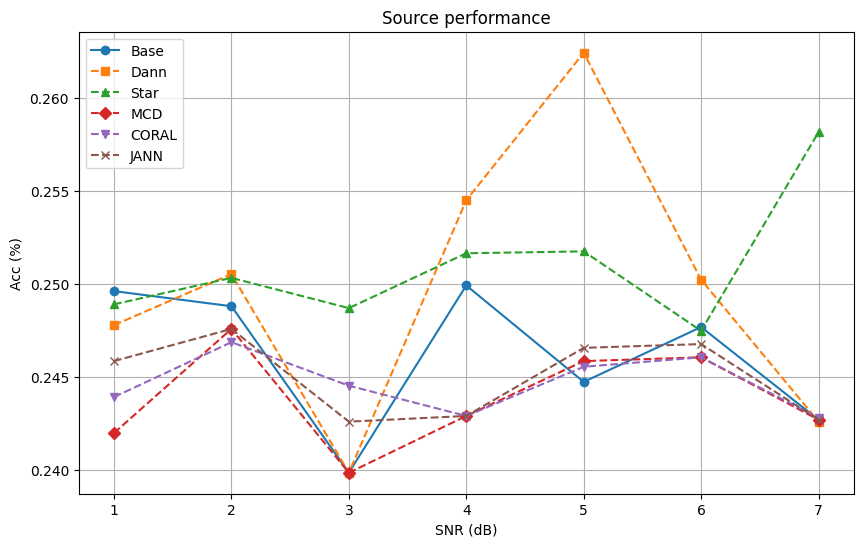

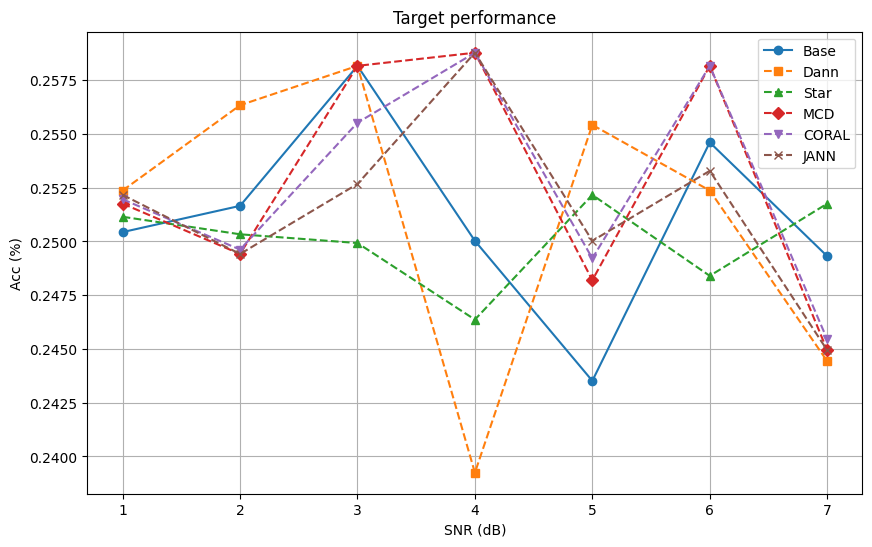

In [6]:
x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, s_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, s_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, s_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, s_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, s_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, s_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Source performance')
plt.legend()
plt.grid(True)
plt.show()


x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()